# Apple Health unstructured Heart Rate data '.rtf' to Readable table '.csv'

In [67]:
import pandas as pd
import re

# Clean and parse the RTF file
def parse_rtf(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    # Remove RTF-specific formatting
    content = re.sub(r'[{}\n\\]', '', content)  # Remove RTF characters
    content = re.sub(r'\s+', ' ', content)  # Replace multiple spaces with a single space
    return content

# Extract relevant heart rate data
def extract_heart_rate_data(content):
    # Split the cleaned content into manageable lines
    data = []
    for match in re.finditer(r'<low value="(?P<timestamp>\d{14}\+\d{4})"/>.*?<value xsi:type="PQ" value="(?P<heart_rate>\d+)" unit="count/min"/>', content):
        try:
            timestamp = match.group('timestamp')
            heart_rate = match.group('heart_rate')
            data.append({
                "timestamp": pd.to_datetime(timestamp, format='%Y%m%d%H%M%S%z'),
                "heart_rate": float(heart_rate)
            })
        except Exception as e:
            print(f"Error processing match: {match.group(0)}, Error: {e}")
    return pd.DataFrame(data)

# Main processing
rtf_file_path = 'export_heartrate_v2.rtf'  # Ensure the file is in the working directory
content = parse_rtf(rtf_file_path)  # Read and clean RTF content
heart_rate_df = extract_heart_rate_data(content)  # Extract heart rate data

# Output the results
if not heart_rate_df.empty:
    print("Extracted Data:")
    print(heart_rate_df)
    # Save to a CSV for further analysis
    heart_rate_df.to_csv('heart_rate_extracted.csv', index=False)
    print("Data saved to 'heart_rate_extracted.csv'")
else:
    print("No valid data found in the file.")

Extracted Data:
                     timestamp  heart_rate
0    2024-09-29 19:01:20+03:00       100.0
1    2024-09-29 19:08:31+03:00       106.0
2    2024-09-29 20:03:54+03:00        94.0
3    2024-09-29 20:07:18+03:00       106.0
4    2024-09-29 20:20:53+03:00        91.0
...                        ...         ...
1814 2024-10-31 18:16:18+03:00        88.0
1815 2024-10-31 18:18:23+03:00       100.0
1816 2024-10-31 18:32:21+03:00       102.0
1817 2024-10-31 18:43:17+03:00        90.0
1818 2024-11-01 09:50:29+03:00        70.0

[1819 rows x 2 columns]
Data saved to 'heart_rate_extracted.csv'


The goal of this code is to extract heart rate data from an RTF (Rich Text Format) file containing health-related information, clean and parse the data, and save it in a structured CSV format for further analysis. Below is a breakdown of the purpose and functionality of each part:

Purpose:
1. Parse and Clean Data:
   - The code processes an RTF file to remove unnecessary formatting and extract meaningful information about heart rate values recorded at specific timestamps.

2. Structure and Save Data:
   - The extracted data is organized into a tabular format (with columns for `timestamp` and `heart_rate`) and saved to a CSV file for easy analysis and visualization.

Detailed Functionality:

1. RTF Parsing and Cleaning:
   - The `parse_rtf` function reads the input RTF file and removes unnecessary characters such as braces (`{}`), backslashes (`\`), and extra whitespace using regular expressions.
   - This step ensures that the remaining content is clean and ready for processing.

2. Data Extraction:
   - The `extract_heart_rate_data` function applies a regular expression pattern to identify and extract timestamps (`<low value>`) and heart rate values (`<value xsi:type>`).
   - The function converts timestamps into a datetime format and heart rate values into floats, creating a list of structured data.

3. Error Handling:
   - Any parsing issues, such as invalid values or formatting errors, are caught, and the error details are printed to help identify problematic records.

4. Data Structuring:
   - The extracted data is converted into a pandas DataFrame, which provides a structured and tabular representation of the data.

5. Saving Data to CSV:
   - The processed data is saved to a CSV file named `heart_rate_extracted.csv`, making it easy to use for further analysis or visualization in tools such as Python, Excel, or Tableau.

6. Validation and Output:
   - If the extraction is successful and data exists, a summary of the extracted data is displayed, and the CSV file is saved.
   - If no valid data is found, a message is printed indicating this outcome.

In [68]:
import pandas as pd

# Load the input CSV file
file_path = 'heart_rate_extracted.csv'  # Input file path
output_file_path = 'heart_rate_extracted_filled.csv'  # Output file path

# Read the CSV file into a DataFrame
heart_rate_df = pd.read_csv(file_path)

# Convert 'timestamp' to datetime format
heart_rate_df['timestamp'] = pd.to_datetime(heart_rate_df['timestamp'])

# Split data into September 28–30 and October 2024
september_data = heart_rate_df.loc[
    (heart_rate_df['timestamp'] >= '2024-09-28') & (heart_rate_df['timestamp'] < '2024-10-01')
].copy()

october_data = heart_rate_df.loc[
    (heart_rate_df['timestamp'] >= '2024-10-01') & (heart_rate_df['timestamp'] < '2024-11-01')
].copy()

# Create a new column for 10-minute periods
september_data['period'] = september_data['timestamp'].dt.floor('10min')
october_data['period'] = october_data['timestamp'].dt.floor('10min')

# Aggregate September data into 10-minute intervals
september_interval_data = (
    september_data.groupby('period')
    .agg(mean_heart_rate=('heart_rate', 'mean'))
    .reset_index()
)

# Round all averages in September data to the nearest .0 or .5
september_interval_data['mean_heart_rate'] = september_interval_data['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Calculate the average of the last 5 data points from September 28–30
last_values = september_interval_data['mean_heart_rate'].iloc[-5:]
last_values_avg = round(last_values.mean() * 2) / 2  # Round to nearest .0 or .5

# Generate 10-minute intervals for October 1st, 00:00:00 to 14:50:00
october_1st_periods = pd.date_range(start='2024-10-01 00:00:00', end='2024-10-01 14:50:00', freq='10min')
october_1st_data = pd.DataFrame({
    'period': october_1st_periods,
    'mean_heart_rate': [last_values_avg] * len(october_1st_periods)
})

# Combine September data with generated October 1st data
september_combined = pd.concat([
    september_interval_data.set_index('period'),
    october_1st_data.set_index('period')
])

# Remove timezone information from September and October 1st data
september_combined.index = pd.to_datetime(september_combined.index, errors='coerce').tz_localize(None)

# Aggregate October data into 10-minute intervals
october_interval_data = (
    october_data.groupby('period')
    .agg(mean_heart_rate=('heart_rate', 'mean'))
    .reset_index()
)

# Round all averages in October data to the nearest .0 or .5
october_interval_data['mean_heart_rate'] = october_interval_data['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Ensure 'period' is a datetime column and remove timezone information
october_interval_data['period'] = pd.to_datetime(october_interval_data['period'], errors='coerce')
october_interval_data['period'] = october_interval_data['period'].dt.tz_localize(None)
october_interval_data.set_index('period', inplace=True)

# Combine September reference and generated October 1st data with remaining October data
combined_data = pd.concat([september_combined, october_interval_data])

# Ensure combined_data.index is timezone-naive
combined_data.index = pd.to_datetime(combined_data.index, errors='coerce').tz_localize(None)

# Remove duplicate indices to avoid reindexing errors
combined_data = combined_data[~combined_data.index.duplicated(keep='first')]

# Reindex to include all 10-minute intervals up to 2024-10-31 23:50:00
all_periods = pd.date_range(
    start=combined_data.index.min(),
    end='2024-10-31 23:50:00',  # Ensure we include the full day of October 31
    freq='10min'
)
combined_data = combined_data.reindex(all_periods)
combined_data.index.name = 'period'

# Fill missing data using the last 5, 4, 3, or 2 available heart rates
for i in range(len(combined_data)):
    if pd.isna(combined_data.iloc[i]['mean_heart_rate']):
        # Try to use the last 5, 4, 3, or 2 valid values
        valid_values = combined_data.iloc[max(0, i - 5):i]['mean_heart_rate'].dropna().values
        if len(valid_values) >= 2:  # Ensure at least two values are available
            filled_value = valid_values.mean()
            # Round to the nearest .0 or .5
            combined_data.iloc[i, combined_data.columns.get_loc('mean_heart_rate')] = round(filled_value * 2) / 2

# Filter to retain only October 2024 data
october_intervals = combined_data.loc[
    (combined_data.index >= pd.Timestamp('2024-10-01')) & (combined_data.index <= pd.Timestamp('2024-10-31 23:50:00'))
].reset_index()

# Save only October 2024 data
october_intervals.to_csv(output_file_path, index=False)

print(f"Processed 10-minute interval data for October saved to '{output_file_path}'")

Processed 10-minute interval data for October saved to 'heart_rate_extracted_filled.csv'


The goal of this code is to preprocess heart rate data from a CSV file, fill missing data, and aggregate the data into 10-minute intervals for October 2024. The processed data is then saved to a CSV file for further analysis. Below is a breakdown of the purpose and functionality of each part:

Purpose:
1. Data Segmentation:
	  -	The code splits the raw data into relevant periods (e.g., September 28–30 and October 2024) to handle each segment separately.
2. Data Aggregation and Filling:
	  -	Heart rate data is aggregated into 10-minute intervals, and missing intervals are filled using averages of preceding valid data points.
3. Data Structuring and Export:
  	-	The processed data is structured into a consistent format and saved for analysis and visualization.

Detailed Functionality:
1. Loading and Preprocessing:
	  -	Reads the input CSV file containing timestamped heart rate data.
	  -	Converts the timestamp column to datetime format to enable time-based operations.	2.	Data Segmentation:
	  -	Filters and splits the data into two subsets:
	  -	September 28–30 data for reference and extrapolation.
	  -	October 2024 data for aggregation and final output.
3. 10-Minute Period Aggregation:
	  -	For both September and October data, timestamps are rounded down to the nearest 10-minute interval (floor('10min')).
	  -	Aggregates heart rate data within each 10-minute interval by calculating the mean.
4. Handling Missing Data:
	  -	Generates missing intervals for October 1st (00:00:00 to 14:50:00) based on the average of the last 5 heart rate values from September.
  	-	Ensures all intervals from October 1st to October 31st are represented by reindexing with a complete range of 10-minute intervals.
5. Filling Missing Values:
	  -	Fills missing heart rate values in the combined data using averages of the last 5, 4, 3, or 2 valid values.
  	-	Rounds the filled averages to the nearest .0 or .5 for consistency.
6. Output Generation:
  	-	Filters the data to retain only October 2024.
  	-	Saves the final processed data to a CSV file (heart_rate_extracted_filled.csv).
7. Validation and Export:
	  -	Prints a confirmation message indicating successful processing and saving of the data.
	  -	The saved file is ready for analysis or visualization.

This code ensures a structured and gap-free dataset, suitable for time-series analysis or health-related insights.

# Daily and Weekly Heart Rates

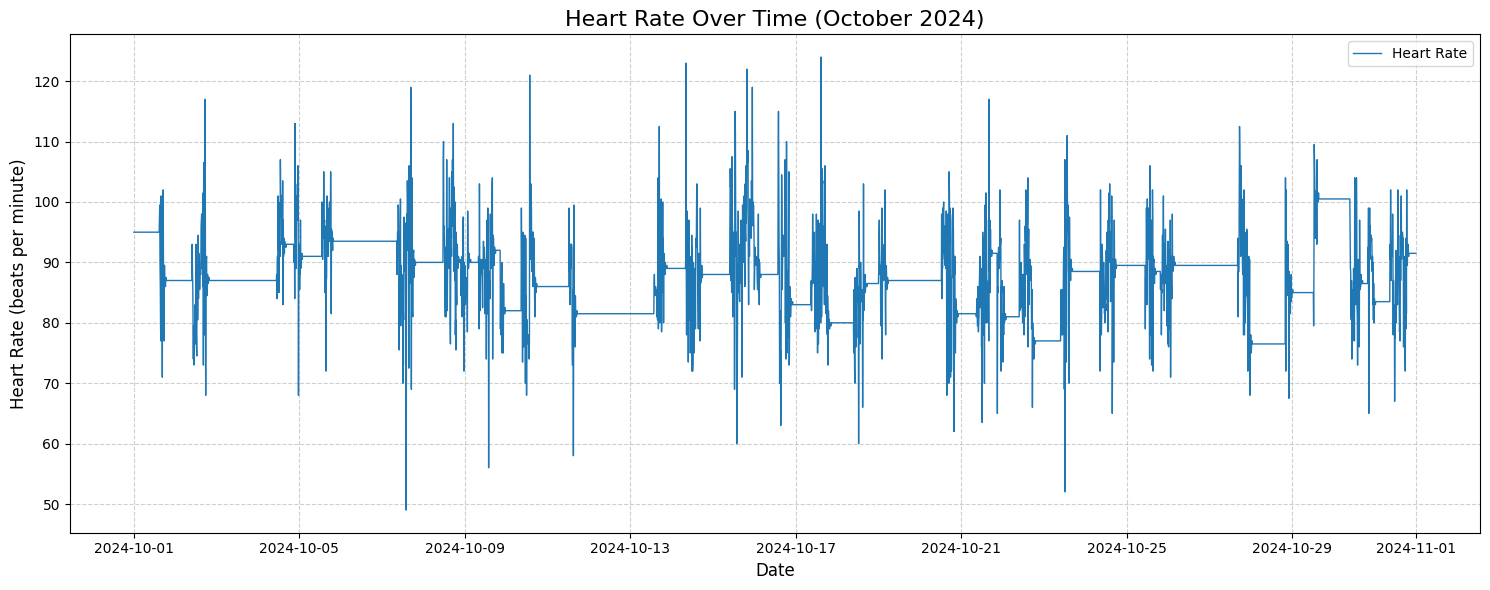

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the processed CSV file
file_path = 'heart_rate_extracted_filled.csv'  # Replace with your file path
processed_data = pd.read_csv(file_path)

# Convert the 'period' column to datetime for plotting
processed_data['period'] = pd.to_datetime(processed_data['period'])

# Create a line chart for date vs. heart rate
plt.figure(figsize=(15, 6))
plt.plot(processed_data['period'], processed_data['mean_heart_rate'], label='Heart Rate', linewidth=1)
plt.title('Heart Rate Over Time (October 2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Heart Rate (beats per minute)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

The goal of this code is to visualize heart rate trends over time for October 2024 using the processed heart rate data. Below is a breakdown of the purpose and functionality of each part:

Purpose:
1. Data Loading:
   - Load the processed heart rate data from a CSV file into a pandas DataFrame.

2. Data Visualization:
   - Generate a line chart that plots the average heart rate (`mean_heart_rate`) over time, showing trends and patterns throughout October 2024.

Detailed Functionality:

1. Data Loading:
   - The CSV file, containing processed heart rate data aggregated into 10-minute intervals, is read into a pandas DataFrame.
   - The `period` column, representing timestamps, is converted to datetime format to facilitate time-series plotting.

2. Plotting Heart Rate Trends:
   - A line chart is created using Matplotlib:
     - The x-axis represents time periods (dates).
     - The y-axis represents average heart rate (in beats per minute).
   - Grid lines are added for better readability.
   - A legend is included to indicate the plotted line represents heart rate data.

3. Chart Customization:
   - The title, axis labels, and other chart elements are customized for clarity and presentation.
   - The chart is designed with a fixed size and tight layout to ensure readability.

4. Output Display:
   - The chart is displayed, providing a visual representation of heart rate trends throughout October 2024.

This visualization is useful for identifying trends, peaks, or irregularities in heart rate data over time.

<ipython-input-70-13e95b4da1dc>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week1_data['date'] = week1_data['period'].dt.date


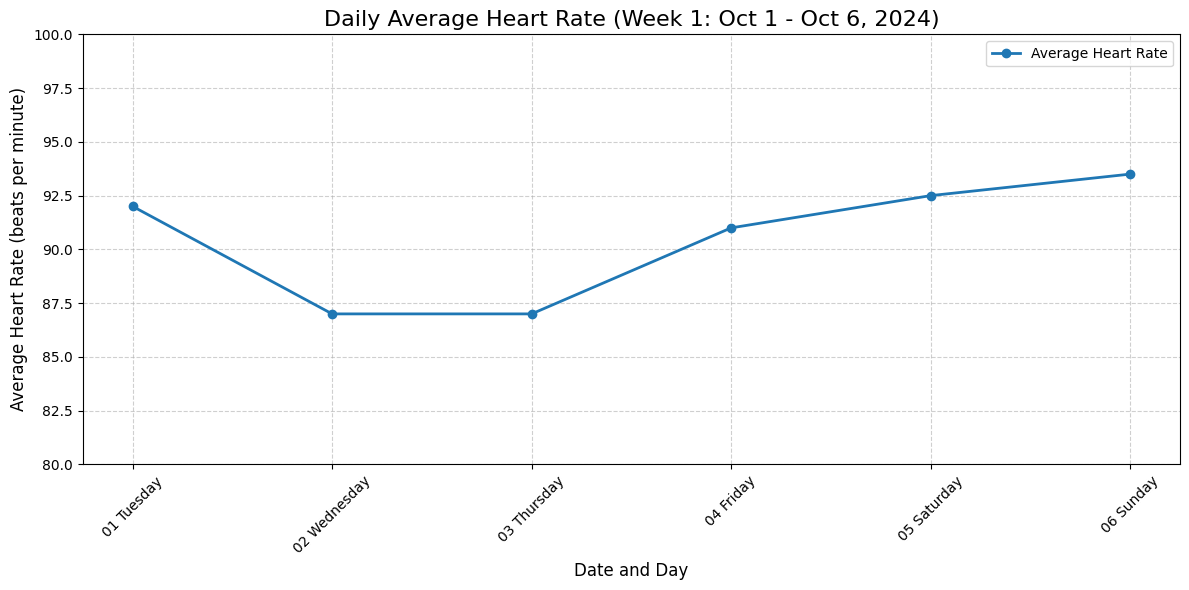

         date  mean_heart_rate           day
0  2024-10-01             92.0    01 Tuesday
1  2024-10-02             87.0  02 Wednesday
2  2024-10-03             87.0   03 Thursday
3  2024-10-04             91.0     04 Friday
4  2024-10-05             92.5   05 Saturday
5  2024-10-06             93.5     06 Sunday


In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the processed CSV file
file_path = 'heart_rate_extracted_filled.csv'  # Replace with your file path
processed_data = pd.read_csv(file_path)

# Convert the 'period' column to datetime for processing
processed_data['period'] = pd.to_datetime(processed_data['period'])

# Filter data for the first week (Tuesday, Oct 1 to Sunday, Oct 6, 2024)
week1_data = processed_data.loc[
    (processed_data['period'] >= '2024-10-01') & (processed_data['period'] < '2024-10-07')
]

# Calculate daily average heart rate for the first week (Oct 1 to Oct 6, 2024)
week1_data['date'] = week1_data['period'].dt.date
daily_average_week1 = week1_data.groupby('date')['mean_heart_rate'].mean().reset_index()

# Add day names to the dates
daily_average_week1['day'] = pd.to_datetime(daily_average_week1['date']).dt.strftime('%d %A')

# Round daily averages to the nearest .0 or .5
daily_average_week1['mean_heart_rate'] = daily_average_week1['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Create a line chart for daily averages in the first week
plt.figure(figsize=(12, 6))
plt.plot(daily_average_week1['day'], daily_average_week1['mean_heart_rate'], marker='o', linestyle='-', linewidth=2, label='Average Heart Rate')
plt.title('Daily Average Heart Rate (Week 1: Oct 1 - Oct 6, 2024)', fontsize=16)
plt.xlabel('Date and Day', fontsize=12)
plt.ylabel('Average Heart Rate (beats per minute)', fontsize=12)
plt.ylim(80, 100)  # Set y-axis limits
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Display daily averages with day names
print(daily_average_week1)

<ipython-input-51-c2c7f5b54586>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week2_data['date'] = week2_data['period'].dt.date


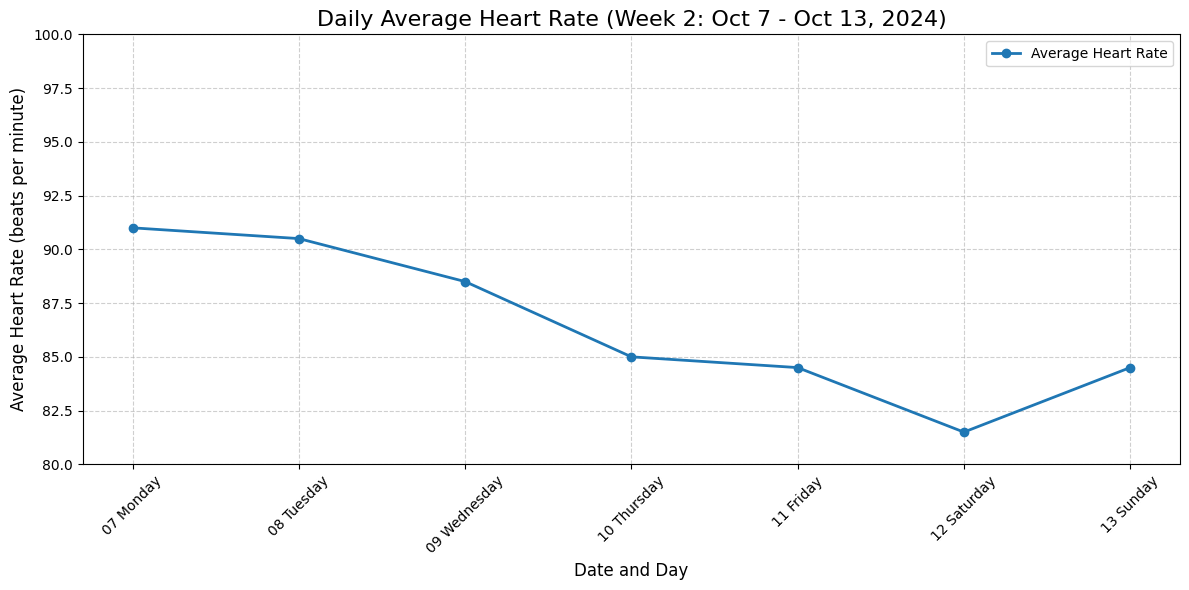

         date  mean_heart_rate           day
0  2024-10-07             91.0     07 Monday
1  2024-10-08             90.5    08 Tuesday
2  2024-10-09             88.5  09 Wednesday
3  2024-10-10             85.0   10 Thursday
4  2024-10-11             84.5     11 Friday
5  2024-10-12             81.5   12 Saturday
6  2024-10-13             84.5     13 Sunday


In [51]:
# Filter data for the second week (Monday, Oct 7 to Sunday, Oct 13, 2024)
week2_data = processed_data.loc[
    (processed_data['period'] >= '2024-10-07') & (processed_data['period'] < '2024-10-14')
]

# Calculate daily average heart rate for the second week (Oct 7 to Oct 13, 2024)
week2_data['date'] = week2_data['period'].dt.date
daily_average_week2 = week2_data.groupby('date')['mean_heart_rate'].mean().reset_index()

# Add day names to the dates
daily_average_week2['day'] = pd.to_datetime(daily_average_week2['date']).dt.strftime('%d %A')

# Round daily averages to the nearest .0 or .5
daily_average_week2['mean_heart_rate'] = daily_average_week2['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Create a line chart for daily averages in the second week
plt.figure(figsize=(12, 6))
plt.plot(daily_average_week2['day'], daily_average_week2['mean_heart_rate'], marker='o', linestyle='-', linewidth=2, label='Average Heart Rate')
plt.title('Daily Average Heart Rate (Week 2: Oct 7 - Oct 13, 2024)', fontsize=16)
plt.xlabel('Date and Day', fontsize=12)
plt.ylabel('Average Heart Rate (beats per minute)', fontsize=12)
plt.ylim(80, 100)  # Set y-axis limits
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Display daily averages with day names
print(daily_average_week2)

<ipython-input-71-3a1dab4773b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week3_data['date'] = week3_data['period'].dt.date


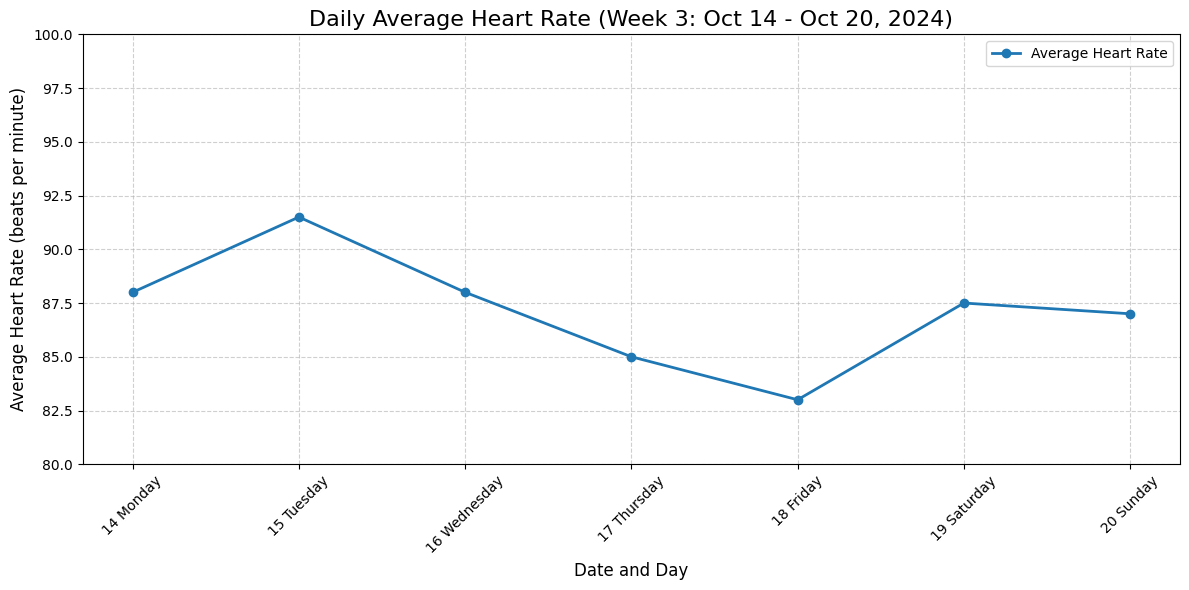

         date  mean_heart_rate           day
0  2024-10-14             88.0     14 Monday
1  2024-10-15             91.5    15 Tuesday
2  2024-10-16             88.0  16 Wednesday
3  2024-10-17             85.0   17 Thursday
4  2024-10-18             83.0     18 Friday
5  2024-10-19             87.5   19 Saturday
6  2024-10-20             87.0     20 Sunday


In [71]:
# Filter data for the third week (Monday, Oct 14 to Sunday, Oct 20, 2024)
week3_data = processed_data.loc[
    (processed_data['period'] >= '2024-10-14') & (processed_data['period'] < '2024-10-21')
]

# Calculate daily average heart rate for the third week (Oct 14 to Oct 20, 2024)
week3_data['date'] = week3_data['period'].dt.date
daily_average_week3 = week3_data.groupby('date')['mean_heart_rate'].mean().reset_index()

# Add day names to the dates
daily_average_week3['day'] = pd.to_datetime(daily_average_week3['date']).dt.strftime('%d %A')

# Round daily averages to the nearest .0 or .5
daily_average_week3['mean_heart_rate'] = daily_average_week3['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Create a line chart for daily averages in the third week
plt.figure(figsize=(12, 6))
plt.plot(daily_average_week3['day'], daily_average_week3['mean_heart_rate'], marker='o', linestyle='-', linewidth=2, label='Average Heart Rate')
plt.title('Daily Average Heart Rate (Week 3: Oct 14 - Oct 20, 2024)', fontsize=16)
plt.xlabel('Date and Day', fontsize=12)
plt.ylabel('Average Heart Rate (beats per minute)', fontsize=12)
plt.ylim(80, 100)  # Set y-axis limits
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Display daily averages with day names
print(daily_average_week3)

<ipython-input-72-83edfba8155a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week4_data['date'] = week4_data['period'].dt.date


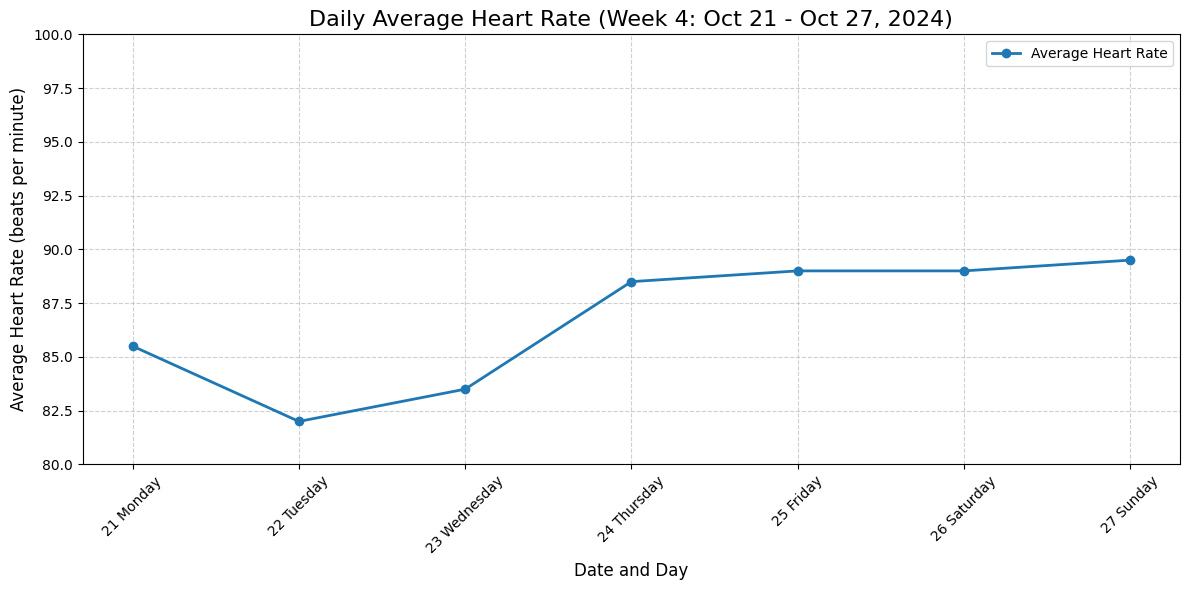

         date  mean_heart_rate           day
0  2024-10-21             85.5     21 Monday
1  2024-10-22             82.0    22 Tuesday
2  2024-10-23             83.5  23 Wednesday
3  2024-10-24             88.5   24 Thursday
4  2024-10-25             89.0     25 Friday
5  2024-10-26             89.0   26 Saturday
6  2024-10-27             89.5     27 Sunday


In [72]:
# Filter data for the 4th week (Monday, Oct 21 to Sunday, Oct 27, 2024)
week4_data = processed_data.loc[
    (processed_data['period'] >= '2024-10-21') & (processed_data['period'] < '2024-10-28')
]

# Calculate daily average heart rate for the 4th week (Oct 21 to Oct 27, 2024)
week4_data['date'] = week4_data['period'].dt.date
daily_average_week4 = week4_data.groupby('date')['mean_heart_rate'].mean().reset_index()

# Add day names to the dates
daily_average_week4['day'] = pd.to_datetime(daily_average_week4['date']).dt.strftime('%d %A')

# Round daily averages to the nearest .0 or .5
daily_average_week4['mean_heart_rate'] = daily_average_week4['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Create a line chart for daily averages in the 4th week
plt.figure(figsize=(12, 6))
plt.plot(daily_average_week4['day'], daily_average_week4['mean_heart_rate'], marker='o', linestyle='-', linewidth=2, label='Average Heart Rate')
plt.title('Daily Average Heart Rate (Week 4: Oct 21 - Oct 27, 2024)', fontsize=16)
plt.xlabel('Date and Day', fontsize=12)
plt.ylabel('Average Heart Rate (beats per minute)', fontsize=12)
plt.ylim(80, 100)  # Set y-axis limits
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Display daily averages with day names
print(daily_average_week4)

<ipython-input-73-0bb61606d9c8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week_data['date'] = last_week_data['period'].dt.date


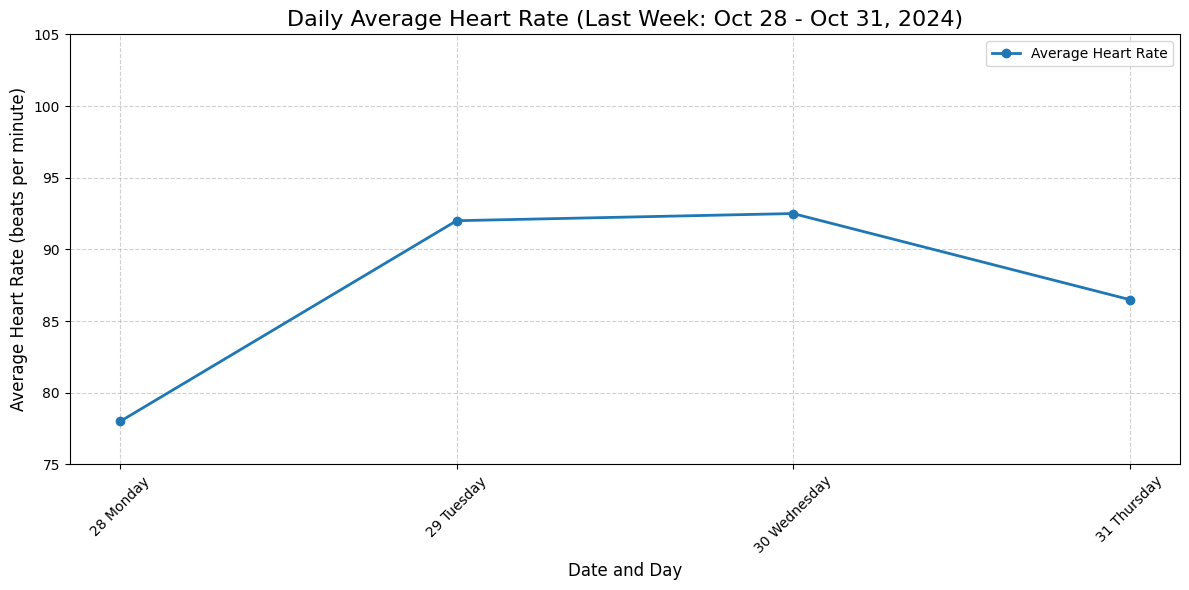

         date  mean_heart_rate           day
0  2024-10-28             78.0     28 Monday
1  2024-10-29             92.0    29 Tuesday
2  2024-10-30             92.5  30 Wednesday
3  2024-10-31             86.5   31 Thursday


In [73]:
# Filter data for the last week (Monday, Oct 28 to Thursday, Oct 31, 2024)
last_week_data = processed_data.loc[
    (processed_data['period'] >= '2024-10-28') & (processed_data['period'] <= '2024-10-31 23:59:59')
]

# Calculate daily average heart rate for the last week (Oct 28 to Oct 31, 2024)
last_week_data['date'] = last_week_data['period'].dt.date
daily_average_last_week = last_week_data.groupby('date')['mean_heart_rate'].mean().reset_index()

# Add day names to the dates
daily_average_last_week['day'] = pd.to_datetime(daily_average_last_week['date']).dt.strftime('%d %A')

# Round daily averages to the nearest .0 or .5
daily_average_last_week['mean_heart_rate'] = daily_average_last_week['mean_heart_rate'].apply(lambda x: round(x * 2) / 2)

# Create a line chart for daily averages in the last week
plt.figure(figsize=(12, 6))
plt.plot(daily_average_last_week['day'], daily_average_last_week['mean_heart_rate'], marker='o', linestyle='-', linewidth=2, label='Average Heart Rate')
plt.title('Daily Average Heart Rate (Last Week: Oct 28 - Oct 31, 2024)', fontsize=16)
plt.xlabel('Date and Day', fontsize=12)
plt.ylabel('Average Heart Rate (beats per minute)', fontsize=12)
plt.ylim(75, 105)  # Set y-axis limits
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Display daily averages with day names
print(daily_average_last_week)

The goal of this Python codes are to calculate and visualize the daily average heart rate for all weeks of October 2024. It also displays the daily averages with their corresponding dates and day names for each week. Below is a detailed explanation:

Purpose:
1. Data Filtering:
	-	Extract heart rate data for each week in October 2024, divided into five predefined weekly ranges.
2. Aggregation and Calculation:
	-	Compute daily average heart rates for each specified week.
	-	Round averages to the nearest .0 or .5 for consistency and clarity.
3. Data Visualization:
	-	Create separate line charts to represent the daily average heart rate for each week.
	-	Annotate the charts with day names for better understanding.

Detailed Functionality:
1. Data Loading and Conversion:
	-	Load the processed heart rate data from a CSV file into a pandas DataFrame.
	-	Convert the period column to datetime format for filtering and processing.
2. Defining Week Ranges:
	-	Define date ranges for all five weeks of October 2024:
	-	Week 1: Oct 1 (Tue) - Oct 6 (Sun)
	-	Week 2: Oct 7 (Mon) - Oct 13 (Sun)
	-	Week 3: Oct 14 (Mon) - Oct 20 (Sun)
	-	Week 4: Oct 21 (Mon) - Oct 27 (Sun)
	-	Week 5: Oct 28 (Mon) - Oct 31 (Thu).
3. Filtering Data for Each Week:
	-	Loop through each defined week range.
	-	Filter the data to include only records within the current week.
4. Daily Aggregation:
	-	Extract the date from the period column and group the data by date for the current week.
	-	Calculate the mean heart rate for each day within the week.
5. Rounding and Formatting:
	-	Round the daily average heart rate values to the nearest .0 or .5.
	-	Add day names (e.g., “01 Tuesday”) to the dates for better readability.
6. Visualization:
	-	For each week:
	-	Create a line chart with:
	-	Dates and day names on the x-axis.
	-	Average heart rates on the y-axis.
	-	A fixed y-axis range of 80 to 100 for consistent scaling.
	-	Grid lines and markers for improved visualization.
	-	Rotate x-axis labels to ensure they are legible.
7. Output:
	-	Display a line chart for each week, showcasing the daily trends in heart rate during that period.
	-	Print a table of daily averages with their corresponding day names for reference.

This visualization approach allows for a detailed week-by-week analysis of heart rate trends and variations throughout October 2024, helping identify patterns and anomalies across different days and weeks.

# Apple Health unstructured Step Count data '.rtf' to Readable table '.csv'

In [74]:
import pandas as pd
import re
import math

# Load the RTF file content
file_path = 'export_stepcount.rtf'

# Extract relevant lines from the RTF
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

# Regular expression to extract records
record_pattern = re.compile(r'<Record.*?type="HKQuantityTypeIdentifierStepCount".*?startDate="(.*?)".*?endDate="(.*?)".*?value="(.*?)"/>')

# Parse the RTF content to extract step count data
data = []
for match in record_pattern.finditer(content):
    start_date, end_date, value = match.groups()
    try:
        step_value = math.ceil(float(value))  # Parse as float and round up
        data.append({
            'startDate': pd.to_datetime(start_date),
            'endDate': pd.to_datetime(end_date),
            'value': step_value
        })
    except ValueError:
        print(f"Skipping invalid value: {value}")

print(f"Extracted {len(data)} records from the RTF file.")

# Create a DataFrame from the parsed data
step_count_df = pd.DataFrame(data)

# Remove timezone information to make timestamps timezone-naive
step_count_df['startDate'] = step_count_df['startDate'].dt.tz_localize(None)
step_count_df['endDate'] = step_count_df['endDate'].dt.tz_localize(None)

# Filter data for October 2024
step_count_df = step_count_df[
    (step_count_df['startDate'] >= '2024-10-01') & (step_count_df['startDate'] < '2024-11-01')
]

# Generate all 10-minute periods for October 2024
all_periods = pd.date_range(start='2024-10-01 00:00:00', end='2024-10-31 23:50:00', freq='10min')

# Create an empty DataFrame for aggregation
step_count_agg = pd.DataFrame({'period': all_periods, 'total_steps': 0})

# Distribute step counts to appropriate intervals without duplication
for _, row in step_count_df.iterrows():
    start = row['startDate']
    end = row['endDate']
    value = row['value']

    # Find overlapping 10-minute intervals
    overlapping_periods = all_periods[(all_periods >= start) & (all_periods < end + pd.Timedelta(minutes=10))]

    if not overlapping_periods.empty:
        for period in overlapping_periods:
            step_count_agg.loc[step_count_agg['period'] == period, 'total_steps'] += value

# Save the processed data to a CSV file
output_file_path = 'step_count_extracted_no_fill.csv'
step_count_agg.to_csv(output_file_path, index=False)

print(f"Processed step count data for October saved to '{output_file_path}'")

Extracted 2035 records from the RTF file.
Processed step count data for October saved to 'step_count_extracted_no_fill.csv'


The goal of this Python code is to extract step count data from an RTF (Rich Text Format) file, clean and process it, and organize the data into 10-minute intervals for the month of October 2024. The processed data is saved in a CSV file for further analysis. Below is a detailed explanation:

Purpose:
1. Data Extraction:
	-	Extract step count data from the RTF file, including timestamps for start and end times of recorded steps.
2. Data Aggregation:
	-	Distribute step counts into 10-minute intervals for October 2024 without duplicating values.
3. Data Structuring and Saving:
	-	Organize the processed data into a tabular format with columns for period and total_steps and save it to a CSV file.

Detailed Functionality:
1. RTF Parsing and Cleaning:
	-	The RTF file is read, and a regular expression pattern (record_pattern) is applied to extract records containing:
	-	Start timestamp (startDate).
	-	End timestamp (endDate).
	-	Step count value (value).
	-	The math.ceil function ensures that fractional step values are rounded up to the nearest integer.
2. Error Handling:
	-	Invalid values are caught during the parsing process, and a message is printed for each skipped record.
3. Data Structuring:
	-	Extracted records are stored in a pandas DataFrame (step_count_df) with columns for start and end timestamps and step count values.
	-	Timestamps are converted to timezone-naive format to simplify processing.
4. Filtering for October 2024:
	-	The DataFrame is filtered to include only records with start timestamps in October 2024.
5. Interval Generation:
	-	A range of 10-minute intervals (all_periods) is generated for the entire month of October 2024.
6. Data Aggregation:
	-	An empty DataFrame (step_count_agg) is created with 10-minute intervals and initialized with zero step counts.
	-	For each record in the parsed data:
	-	The overlapping 10-minute intervals are identified.
	-	Step counts are distributed across these intervals, ensuring no duplication.
7. Data Output:
	-	The processed data is saved to a CSV file named step_count_extracted_no_fill.csv, which includes columns for:
	-	period: 10-minute time intervals.
	-	total_steps: Total step counts for each interval.
	-	A message confirms successful saving of the processed data.

This approach provides a structured representation of step count data for October 2024, organized into 10-minute intervals, which can be used for further analysis or visualization.

# Daily and Weekly Step Counts

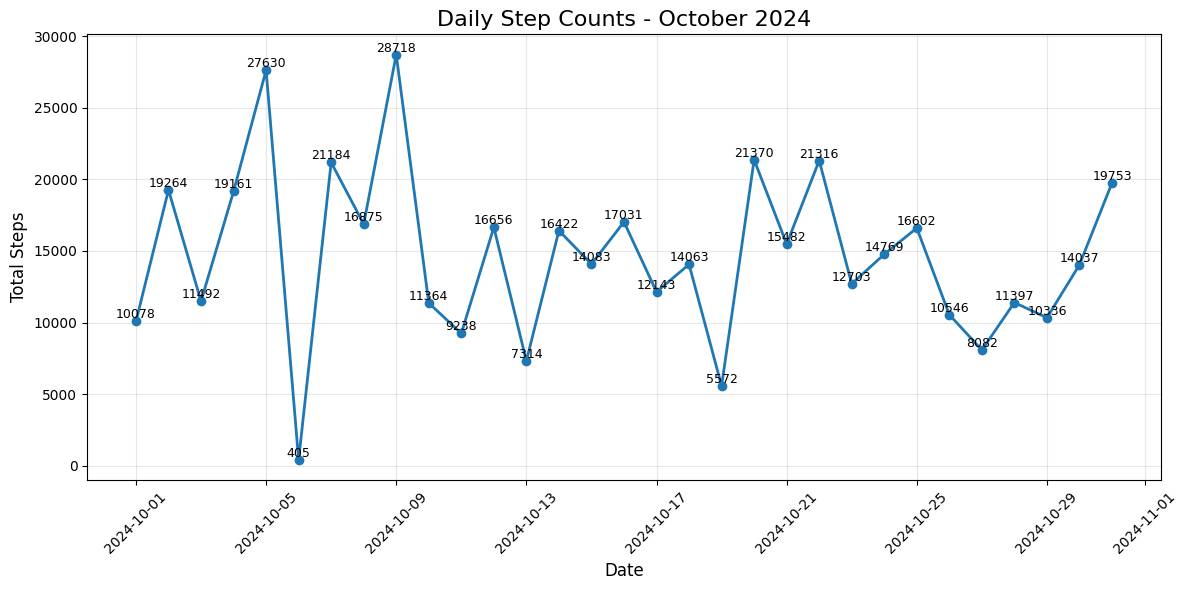

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the step count data
file_path = 'step_count_extracted_no_fill.csv'  # Updated file name
step_count_df = pd.read_csv(file_path)

# Convert 'period' to datetime format
step_count_df['period'] = pd.to_datetime(step_count_df['period'])

# Extract the date from the 'period' column
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate the daily total step counts
daily_step_counts = step_count_df.groupby('date')['total_steps'].sum().reset_index()

# Rename columns for clarity
daily_step_counts.columns = ['Date', 'Total Steps']

# Plot the daily step counts
plt.figure(figsize=(12, 6))
plt.plot(daily_step_counts['Date'], daily_step_counts['Total Steps'], marker='o', linestyle='-', linewidth=2)

# Customize the graph
plt.title('Daily Step Counts - October 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Steps', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.3)

# Add markers for data points
for i, row in daily_step_counts.iterrows():
    plt.text(row['Date'], row['Total Steps'], str(row['Total Steps']), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The goal of this Python code is to calculate and visualize the daily total step counts for October 2024 from processed step count data. Below is a detailed explanation:

Purpose:
1. Data Aggregation:
	-	Compute the total number of steps recorded for each day in October 2024.
2. Data Visualization:
	-	Create a line chart showing the daily total step counts for October 2024.

Detailed Functionality:
1. Data Loading and Conversion:
	-	Load the processed step count data from a CSV file (step_count_extracted_no_fill.csv) into a pandas DataFrame.
	-	Convert the period column to datetime format for easy extraction and aggregation.
2. Daily Aggregation:
	-	Extract the date from the period column using .dt.date.
	-	Group the data by date and compute the sum of the total_steps for each day.
	-	Store the aggregated data in a new DataFrame (daily_step_counts) with columns for Date and Total Steps.
3. Data Visualization:
	-	Use matplotlib to create a line chart:
	-	Plot the dates on the x-axis and the total step counts on the y-axis.
	-	Mark data points with circles and connect them with a line for better readability.
	-	Customize the chart with:
	-	A title (Daily Step Counts - October 2024) to indicate the purpose of the visualization.
	-	Labels for the x-axis (Date) and y-axis (Total Steps).
	-	Rotated x-axis labels for better readability.
	-	A grid with reduced opacity for visual clarity.
4. Annotations:
	-	Add markers with exact step count values above each data point for a precise overview.
5. Output:
	-	Display the line chart, which provides an overview of daily step count trends for October 2024, highlighting periods of high and low activity.

This visualization helps identify patterns and variations in daily physical activity throughout the month of October 2024


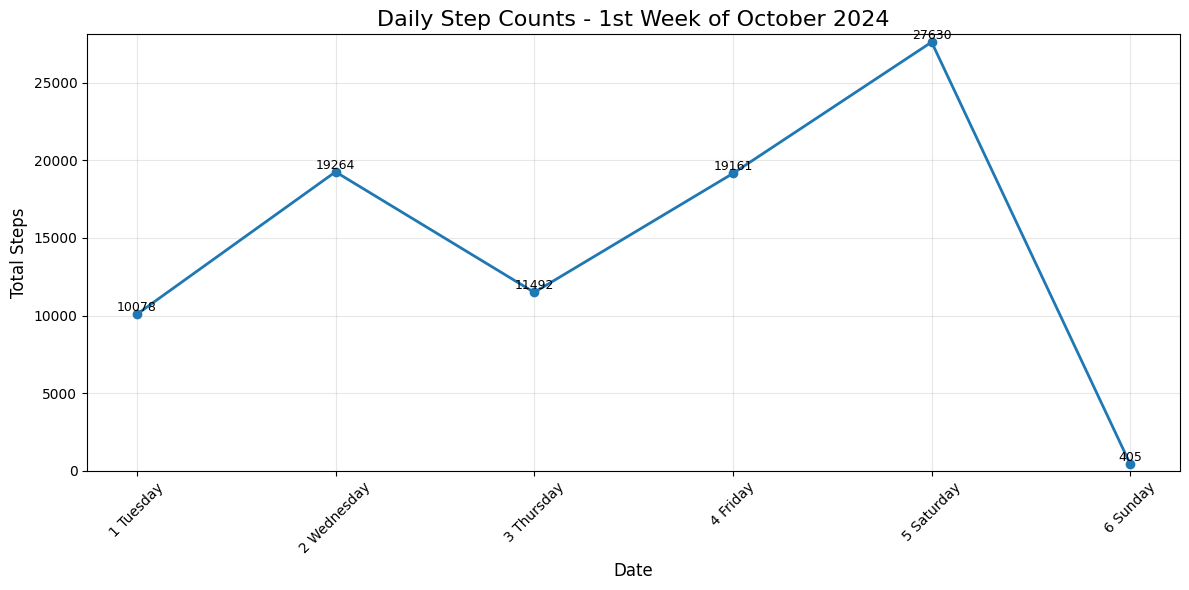

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the step count data
file_path = 'step_count_extracted_no_fill.csv'
step_count_df = pd.read_csv(file_path)

# Convert 'period' to datetime format
step_count_df['period'] = pd.to_datetime(step_count_df['period'])
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate daily total step counts
daily_step_counts = step_count_df.groupby('date')['total_steps'].sum().reset_index()
daily_step_counts.columns = ['Date', 'Total Steps']

# Add weekday information
daily_step_counts['Weekday'] = pd.to_datetime(daily_step_counts['Date']).dt.strftime('%A')

# Filter data for the 1st week (1st October to 6th October, Tuesday to Sunday)
first_week = daily_step_counts[
    (daily_step_counts['Date'] >= pd.Timestamp('2024-10-01').date()) &
    (daily_step_counts['Date'] <= pd.Timestamp('2024-10-06').date())
]

# Plot the daily step counts for the 1st week
plt.figure(figsize=(12, 6))
plt.plot(first_week['Date'], first_week['Total Steps'], marker='o', linestyle='-', linewidth=2)

# Customize the graph
plt.title('Daily Step Counts - 1st Week of October 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Steps', fontsize=12)
plt.xticks(first_week['Date'], labels=[f"{d.day} {w}" for d, w in zip(first_week['Date'], first_week['Weekday'])], rotation=45)
plt.yticks(fontsize=10)
plt.ylim(0, max(first_week['Total Steps'].max() + 500, 5000))  # Dynamically adjust y-axis range
plt.grid(alpha=0.3)

# Add markers for data points
for i, row in first_week.iterrows():
    plt.text(row['Date'], row['Total Steps'], str(row['Total Steps']), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

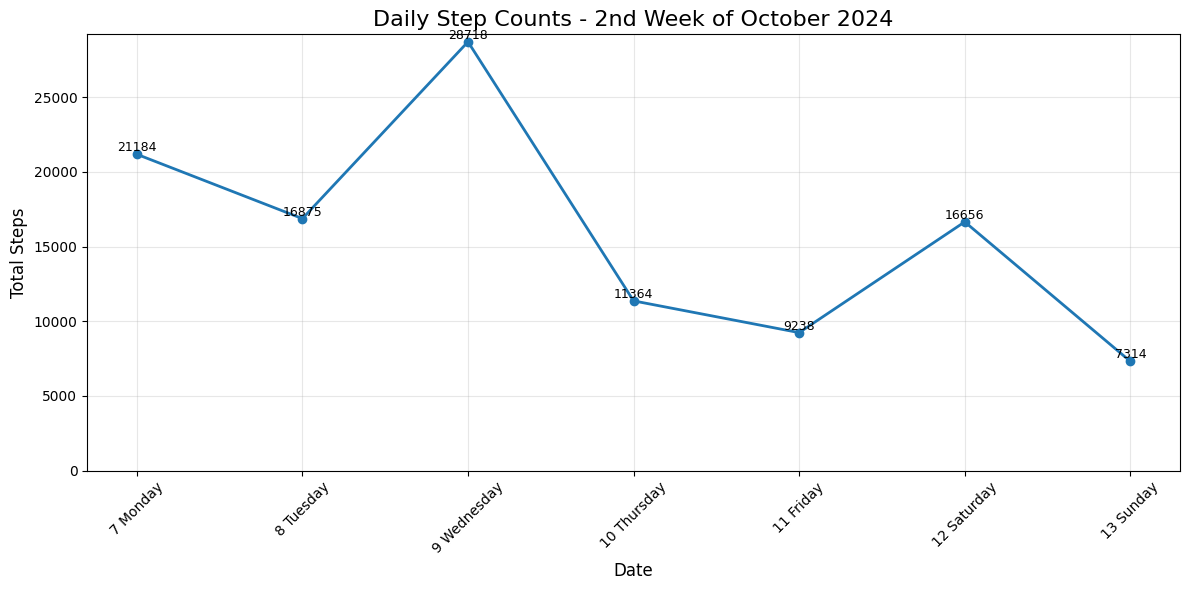

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the step count data
file_path = 'step_count_extracted_no_fill.csv'
step_count_df = pd.read_csv(file_path)

# Convert 'period' to datetime format
step_count_df['period'] = pd.to_datetime(step_count_df['period'])
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate daily total step counts
daily_step_counts = step_count_df.groupby('date')['total_steps'].sum().reset_index()
daily_step_counts.columns = ['Date', 'Total Steps']

# Add weekday information
daily_step_counts['Weekday'] = pd.to_datetime(daily_step_counts['Date']).dt.strftime('%A')

# Filter data for the 2nd week (7th October to 13th October, Monday to Sunday)
second_week = daily_step_counts[
    (daily_step_counts['Date'] >= pd.Timestamp('2024-10-07').date()) &
    (daily_step_counts['Date'] <= pd.Timestamp('2024-10-13').date())
]

# Plot the daily step counts for the 2nd week
plt.figure(figsize=(12, 6))
plt.plot(second_week['Date'], second_week['Total Steps'], marker='o', linestyle='-', linewidth=2)

# Customize the graph
plt.title('Daily Step Counts - 2nd Week of October 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Steps', fontsize=12)
plt.xticks(second_week['Date'], labels=[f"{d.day} {w}" for d, w in zip(second_week['Date'], second_week['Weekday'])], rotation=45)
plt.yticks(fontsize=10)
plt.ylim(0, max(second_week['Total Steps'].max() + 500, 5000))  # Dynamically adjust y-axis range
plt.grid(alpha=0.3)

# Add markers for data points
for i, row in second_week.iterrows():
    plt.text(row['Date'], row['Total Steps'], str(row['Total Steps']), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

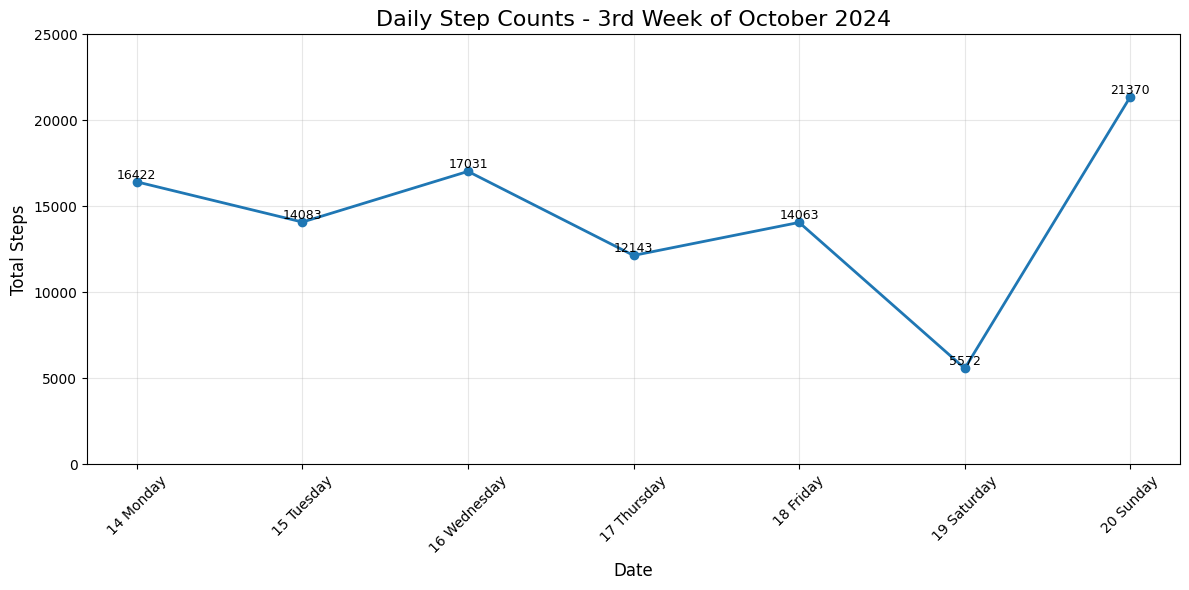

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the step count data
file_path = 'step_count_extracted_no_fill.csv'
step_count_df = pd.read_csv(file_path)

# Convert 'period' to datetime format
step_count_df['period'] = pd.to_datetime(step_count_df['period'])
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate daily total step counts
daily_step_counts = step_count_df.groupby('date')['total_steps'].sum().reset_index()
daily_step_counts.columns = ['Date', 'Total Steps']

# Add weekday information
daily_step_counts['Weekday'] = pd.to_datetime(daily_step_counts['Date']).dt.strftime('%A')

# Filter data for the 3rd week (14th October to 20th October, Monday to Sunday)
third_week = daily_step_counts[
    (daily_step_counts['Date'] >= pd.Timestamp('2024-10-14').date()) &
    (daily_step_counts['Date'] <= pd.Timestamp('2024-10-20').date())
]

# Plot the daily step counts for the 3rd week
plt.figure(figsize=(12, 6))
plt.plot(third_week['Date'], third_week['Total Steps'], marker='o', linestyle='-', linewidth=2)

# Customize the graph
plt.title('Daily Step Counts - 3rd Week of October 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Steps', fontsize=12)
plt.xticks(third_week['Date'], labels=[f"{d.day} {w}" for d, w in zip(third_week['Date'], third_week['Weekday'])], rotation=45)
plt.yticks(fontsize=10)
plt.ylim(0, 25000)  # Fixed y-axis range to 25,000 steps
plt.grid(alpha=0.3)

# Add markers for data points
for i, row in third_week.iterrows():
    plt.text(row['Date'], row['Total Steps'], str(row['Total Steps']), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

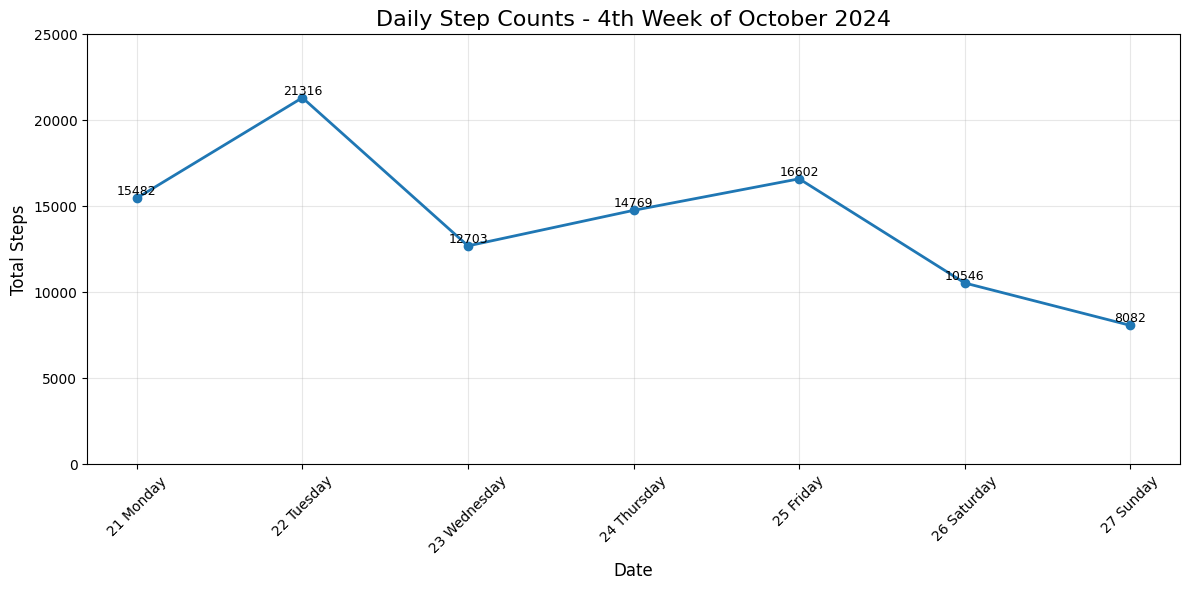

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the step count data
file_path = 'step_count_extracted_no_fill.csv'
step_count_df = pd.read_csv(file_path)

# Convert 'period' to datetime format
step_count_df['period'] = pd.to_datetime(step_count_df['period'])
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate daily total step counts
daily_step_counts = step_count_df.groupby('date')['total_steps'].sum().reset_index()
daily_step_counts.columns = ['Date', 'Total Steps']

# Add weekday information
daily_step_counts['Weekday'] = pd.to_datetime(daily_step_counts['Date']).dt.strftime('%A')

# Filter data for the 4th week (21st October to 27th October, Monday to Sunday)
fourth_week = daily_step_counts[
    (daily_step_counts['Date'] >= pd.Timestamp('2024-10-21').date()) &
    (daily_step_counts['Date'] <= pd.Timestamp('2024-10-27').date())
]

# Plot the daily step counts for the 4th week
plt.figure(figsize=(12, 6))
plt.plot(fourth_week['Date'], fourth_week['Total Steps'], marker='o', linestyle='-', linewidth=2)

# Customize the graph
plt.title('Daily Step Counts - 4th Week of October 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Steps', fontsize=12)
plt.xticks(fourth_week['Date'], labels=[f"{d.day} {w}" for d, w in zip(fourth_week['Date'], fourth_week['Weekday'])], rotation=45)
plt.yticks(fontsize=10)
plt.ylim(0, 25000)  # Fixed y-axis range to 25,000 steps
plt.grid(alpha=0.3)

# Add markers for data points
for i, row in fourth_week.iterrows():
    plt.text(row['Date'], row['Total Steps'], str(row['Total Steps']), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

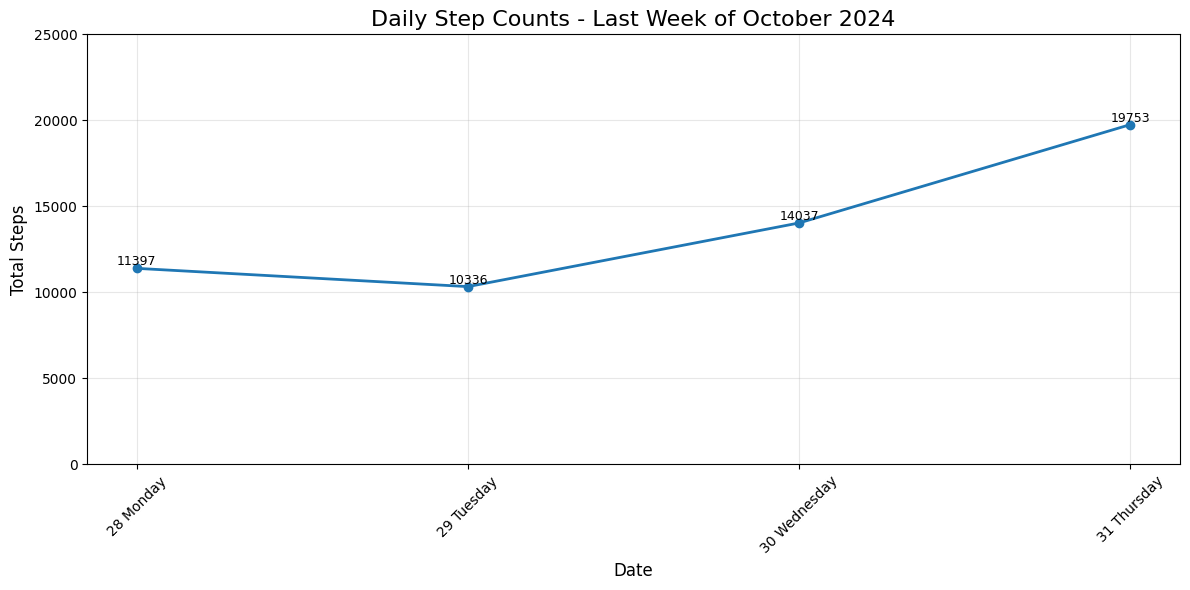

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the step count data
file_path = 'step_count_extracted_no_fill.csv'
step_count_df = pd.read_csv(file_path)

# Convert 'period' to datetime format
step_count_df['period'] = pd.to_datetime(step_count_df['period'])
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate daily total step counts
daily_step_counts = step_count_df.groupby('date')['total_steps'].sum().reset_index()
daily_step_counts.columns = ['Date', 'Total Steps']

# Add weekday information
daily_step_counts['Weekday'] = pd.to_datetime(daily_step_counts['Date']).dt.strftime('%A')

# Filter data for the 5th week (28th October to 31st October, Monday to Thursday)
fifth_week = daily_step_counts[
    (daily_step_counts['Date'] >= pd.Timestamp('2024-10-28').date()) &
    (daily_step_counts['Date'] <= pd.Timestamp('2024-10-31').date())
]

# Plot the daily step counts for the 5th week
plt.figure(figsize=(12, 6))
plt.plot(fifth_week['Date'], fifth_week['Total Steps'], marker='o', linestyle='-', linewidth=2)

# Customize the graph
plt.title('Daily Step Counts - Last Week of October 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Steps', fontsize=12)
plt.xticks(fifth_week['Date'], labels=[f"{d.day} {w}" for d, w in zip(fifth_week['Date'], fifth_week['Weekday'])], rotation=45)
plt.yticks(fontsize=10)
plt.ylim(0, 25000)  # Fixed y-axis range to 25,000 steps
plt.grid(alpha=0.3)

# Add markers for data points
for i, row in fifth_week.iterrows():
    plt.text(row['Date'], row['Total Steps'], str(row['Total Steps']), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The goal of these five Python codes are calculating and visualize the daily total step counts for each week in October 2024, starting with the first week. Below is a detailed explanation for this process:

Purpose:
1. Weekly Data Aggregation:
	-	Compute the total step counts for each day within a specified week.
2. Data Visualization:
	-	Create a line chart for each week, showing daily step counts with corresponding dates and weekday names.

Detailed Functionality:
1. Data Loading and Preparation:
	-	Load the processed step count data from a CSV file (step_count_extracted_no_fill.csv) into a pandas DataFrame.
	-	Convert the period column to datetime format for time-based processing.
	-	Extract the date from the period column and create a new column (date) for easier daily aggregation.
2. Daily Aggregation:
	-	Group the data by the date column and calculate the total step counts for each day.
	-	Store the aggregated data in a new DataFrame (daily_step_counts) with columns for Date and Total Steps.
3. Add Weekday Information:
	-	Add a Weekday column by converting the Date column to the corresponding weekday name (e.g., Tuesday, Wednesday).
4.	Filter Data for Specific Weeks:
	-	For the 5 week (Oct 1 to Oct 31, 2024):
	-	Filter the data to include only records within the date range.
	-	Create a similar process for all the weeks.
5. Visualization:
	-	Use matplotlib to create a line chart for the filtered week:
	-	Plot dates on the x-axis and total step counts on the y-axis.
	-	Annotate each data point with the exact step count value.
	-	Customize the chart with:
	-	A title indicating the week and year (e.g., Daily Step Counts - 1st Week of October 2024).
	-	Labels for the x-axis (Date) and y-axis (Total Steps).
	-	X-axis labels formatted with day and weekday names (e.g., 1 Tuesday).
	-	A grid for better readability.
6. Dynamic Y-axis Adjustment:
	-	Automatically adjust the y-axis range to include a buffer above the maximum step count or a minimum default range.
7. Output:
	-	Display the line chart for the specified week, providing insights into daily activity trends.
	-	Highlight high and low activity days with visual markers.

# Heart Rate and Step Count Analysis

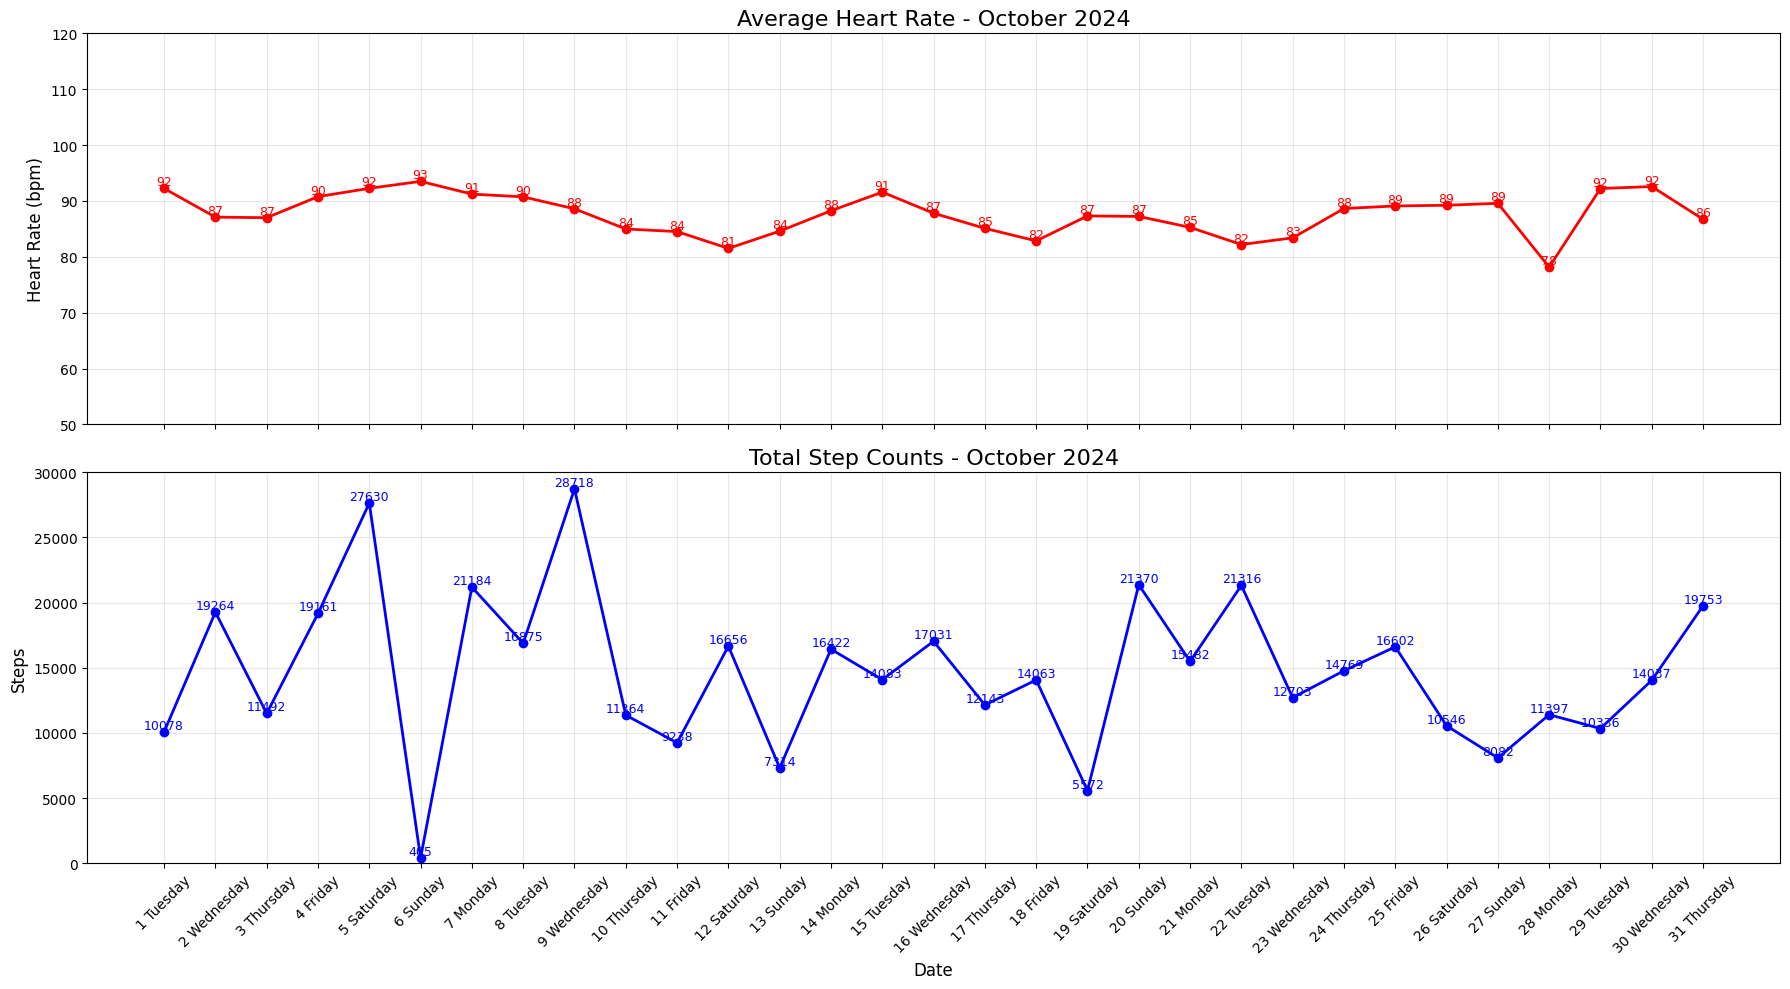

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the heart rate and step count data
heart_rate_file = 'heart_rate_extracted_filled.csv'
step_count_file = 'step_count_extracted_no_fill.csv'

heart_rate_df = pd.read_csv(heart_rate_file)
step_count_df = pd.read_csv(step_count_file)

# Convert 'period' to datetime format
heart_rate_df['period'] = pd.to_datetime(heart_rate_df['period'])
step_count_df['period'] = pd.to_datetime(step_count_df['period'])

# Add dates for grouping
heart_rate_df['date'] = heart_rate_df['period'].dt.date
step_count_df['date'] = step_count_df['period'].dt.date

# Calculate daily average heart rate and total steps
daily_heart_rate = heart_rate_df.groupby('date')['mean_heart_rate'].mean().reset_index()
daily_heart_rate.columns = ['Date', 'Average Heart Rate']

daily_step_count = step_count_df.groupby('date')['total_steps'].sum().reset_index()
daily_step_count.columns = ['Date', 'Total Steps']

# Add weekday information
daily_heart_rate['Weekday'] = pd.to_datetime(daily_heart_rate['Date']).dt.strftime('%A')
daily_step_count['Weekday'] = pd.to_datetime(daily_step_count['Date']).dt.strftime('%A')

# Plot the graphs
fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Plot heart rate
axs[0].plot(daily_heart_rate['Date'], daily_heart_rate['Average Heart Rate'],
            marker='o', linestyle='-', linewidth=2, color='red')
axs[0].set_title('Average Heart Rate - October 2024', fontsize=16)
axs[0].set_ylabel('Heart Rate (bpm)', fontsize=12)
axs[0].set_ylim(50, 120)  # Adjust y-axis range for heart rates
axs[0].grid(alpha=0.3)
for i, row in daily_heart_rate.iterrows():
    axs[0].text(row['Date'], row['Average Heart Rate'], f"{int(row['Average Heart Rate'])}",
                ha='center', va='bottom', fontsize=9, color='red')

# Plot step counts
axs[1].plot(daily_step_count['Date'], daily_step_count['Total Steps'],
            marker='o', linestyle='-', linewidth=2, color='blue')
axs[1].set_title('Total Step Counts - October 2024', fontsize=16)
axs[1].set_ylabel('Steps', fontsize=12)
axs[1].set_ylim(0, 30000)  # Adjust y-axis range for step counts
axs[1].grid(alpha=0.3)
for i, row in daily_step_count.iterrows():
    axs[1].text(row['Date'], row['Total Steps'], f"{row['Total Steps']}",
                ha='center', va='bottom', fontsize=9, color='blue')

# Add shared x-axis
axs[1].set_xlabel('Date', fontsize=12)
plt.xticks(daily_heart_rate['Date'],
           labels=[f"{d.day} {w}" for d, w in zip(daily_heart_rate['Date'], daily_heart_rate['Weekday'])],
           rotation=45)

plt.tight_layout()
plt.show()

The goal of this Python code is to calculate and visualize daily average heart rates and total step counts for October 2024 in two separate yet connected graphs. By presenting both metrics side by side, the code enables an easy comparison between physical activity levels (step counts) and corresponding heart rate trends.
Below is a detailed explanation:

Purpose:
1. Combine and Aggregate Data:
	-	Integrate heart rate and step count data to calculate daily averages and totals.
2. Data Visualization:
	-	Create two aligned line charts:
	-	One for daily average heart rates.
	-	Another for daily total step counts.
	-	Display trends over October 2024 with annotations for clarity.
3. Unified Presentation:
	-	Present heart rate and step count data in the same figure to highlight potential correlations between physical activity and cardiovascular response.

Detailed Functionality:
1. Data Loading and Preparation:
	-	Load heart rate and step count data from their respective CSV files into pandas DataFrames.
	-	Convert the period column in both datasets to datetime format for time-based operations.
	-	Extract the date portion of the period column to enable daily aggregation.
2. Daily Aggregation:
	-	For heart rates:
	-	Group data by date and compute the mean heart rate for each day.
	-	Store the results in a new DataFrame (daily_heart_rate) with columns Date and Average Heart Rate.
	-	For step counts:
	-	Group data by date and compute the total steps for each day.
	-	Store the results in a new DataFrame (daily_step_count) with columns Date and Total Steps.
3. Add Weekday Information:
	-	Add a Weekday column to both datasets by converting the Date column to their corresponding weekday names (e.g., “Tuesday”).
4. Visualization:
	-	Use matplotlib to create a figure with two subplots:
	-	The first subplot (axs[0]) visualizes daily average heart rates:
	-	Use a red line with markers for data points.
	-	Annotate each point with the rounded average heart rate.
	-	Set the y-axis range to 50–120 bpm for better scaling.
	-	The second subplot (axs[1]) visualizes daily total step counts:
	-	Use a blue line with markers for data points.
	-	Annotate each point with the total step count.
	-	Set the y-axis range to 0–30,000 steps.
	-	Share the x-axis between the two graphs to align dates.
5. Enhancements for Readability:
	-	Rotate x-axis labels to ensure date and weekday names are easily legible.
	-	Add gridlines and adjust margins for a clean layout.
	-	Title each graph to clearly indicate the metric being displayed.
6. Unified Presentation:
	-	Presenting both metrics together highlights potential relationships:
	-	Higher step counts may correspond with elevated heart rates due to increased physical activity.
	-	Lower step counts may align with more stable or resting heart rates.
	-	This approach allows for intuitive analysis of activity and cardiovascular response trends on the same timeline.
7. Output:
	-	Display the line charts together, showing how daily heart rates and step counts vary over October 2024.
	-	Annotate data points with their respective values to highlight specific trends.

Why Show Both Metrics in the Same Figure?

-	Correlation Insights: By juxtaposing step counts and heart rates, patterns such as increased activity leading to higher heart rates can be identified.
-	Holistic Health Overview: The unified presentation provides a comprehensive view of physical activity and cardiovascular response on a single timeline.
-	Efficiency: Consolidating these metrics into one figure simplifies the analysis and interpretation process, reducing the need to cross-reference separate graphs.

This visualization helps to correlate patterns between daily physical activity (step counts) and average heart rates, providing insights into lifestyle and health metrics.

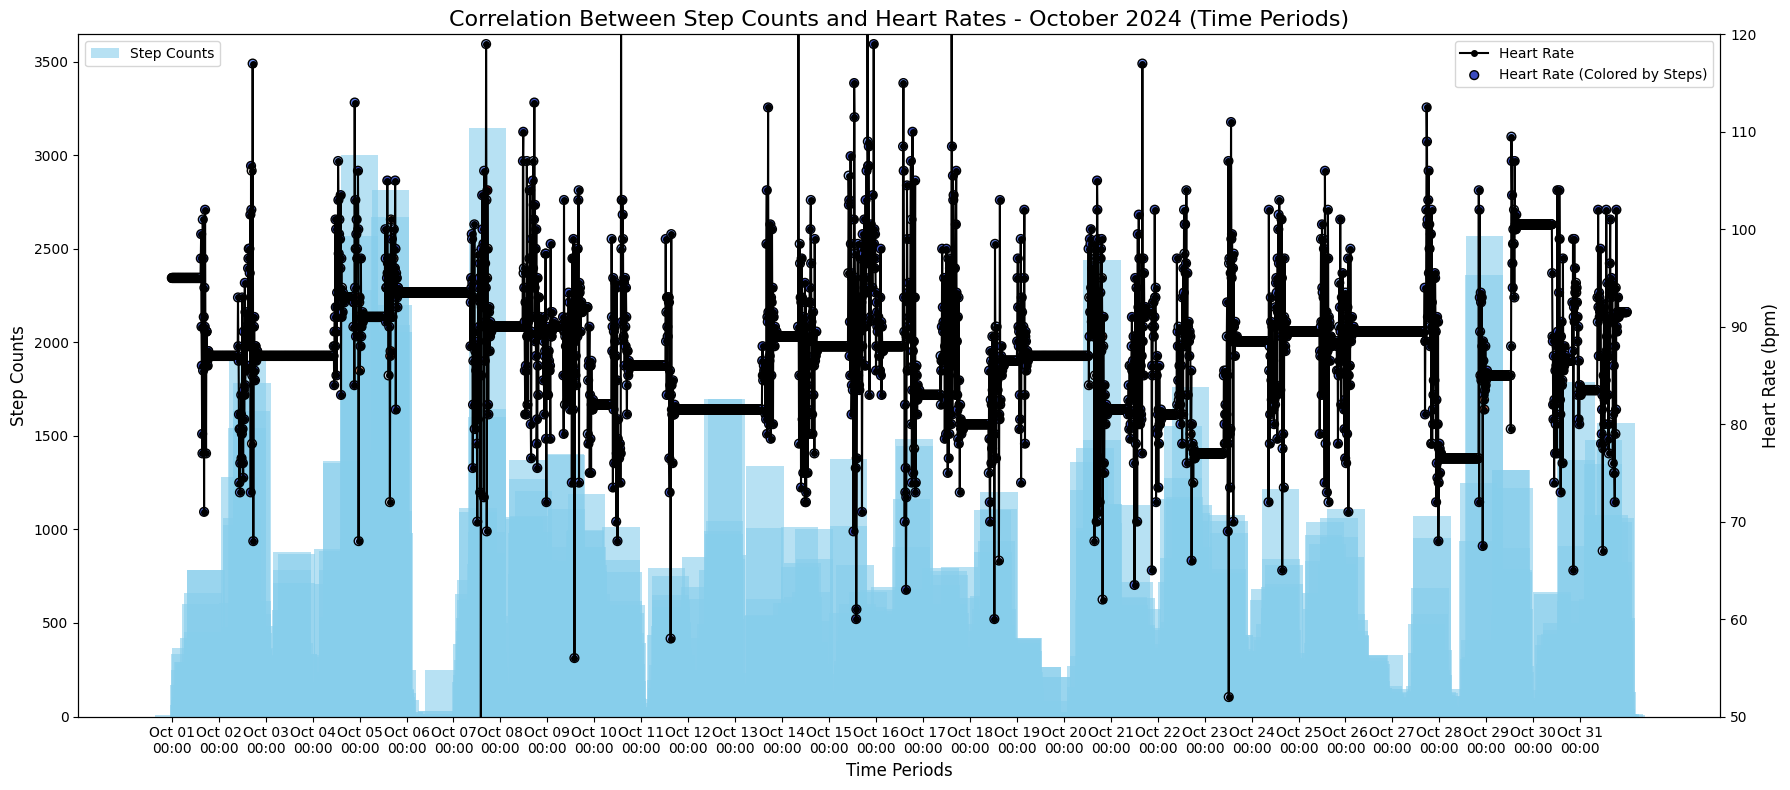

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the heart rate and step count data
heart_rate_file = 'heart_rate_extracted_filled.csv'
step_count_file = 'step_count_extracted_no_fill.csv'

heart_rate_df = pd.read_csv(heart_rate_file)
step_count_df = pd.read_csv(step_count_file)

# Convert 'period' to datetime format
heart_rate_df['period'] = pd.to_datetime(heart_rate_df['period'])
step_count_df['period'] = pd.to_datetime(step_count_df['period'])

# Merge heart rate and step count data on the time period
merged_data = pd.merge(heart_rate_df, step_count_df, on='period', how='outer')
merged_data = merged_data.sort_values(by='period').reset_index(drop=True)

# Normalize step counts for color intensity
merged_data['Step Intensity'] = (merged_data['total_steps'] - merged_data['total_steps'].min()) / (
    merged_data['total_steps'].max() - merged_data['total_steps'].min()
)

# Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Bar chart for step counts
ax1.bar(
    merged_data['period'],
    merged_data['total_steps'],
    color='skyblue',
    alpha=0.6,
    label='Step Counts'
)
ax1.set_ylabel('Step Counts', fontsize=12)
ax1.set_ylim(0, merged_data['total_steps'].max() + 500)

# Second axis for heart rate
ax2 = ax1.twinx()
colors = plt.cm.coolwarm(merged_data['Step Intensity'].fillna(0))  # Map intensity to colors
ax2.plot(
    merged_data['period'],
    merged_data['mean_heart_rate'],
    color='black',
    marker='o',
    markersize=4,
    linestyle='-',
    linewidth=1.5,
    label='Heart Rate'
)
ax2.scatter(
    merged_data['period'],
    merged_data['mean_heart_rate'],
    c=colors,
    s=40,
    edgecolor='black',
    label='Heart Rate (Colored by Steps)'
)
ax2.set_ylabel('Heart Rate (bpm)', fontsize=12)
ax2.set_ylim(50, 120)

# Title and legends
ax1.set_title('Correlation Between Step Counts and Heart Rates - October 2024 (Time Periods)', fontsize=16)
ax1.set_xlabel('Time Periods', fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust x-axis for readability
plt.xticks(
    merged_data['period'][::144],  # Show tick every ~144 periods (about a day)
    labels=[p.strftime('%b %d\n%H:%M') for p in merged_data['period'][::144]],
    rotation=45
)

plt.tight_layout()
plt.show()

The Differences Between Code 1 and Code 2:
1. Data Level:
	-	Code 1: Summarizes the data into daily averages and totals, focusing on broader trends.
	-	Code 2: Analyzes detailed 10-minute intervals to highlight short-term patterns and relationships.
2. Visualization:
	-	Code 1: Creates two separate line graphs:
	-	The first graph shows daily average heart rates.
	-	The second graph displays daily total step counts.
	-	Code 2: Combines a bar chart (step counts) with a line and scatter plot (heart rates), using color intensity to reflect step activity.
3. Focus:
	- Code 1: Focuses on high-level daily trends across the entire month of October 2024.
	-	Code 2: Dives into intra-day variations and explores the correlation between activity levels and cardiovascular responses.
4. Annotations:
	-	Code 1: Marks data points on the graphs with exact values, providing clear daily insights.
  -	Code 2: Uses color-coded markers to visually link heart rate fluctuations to step intensity, emphasizing active periods.
  Purpose:
	-	Code 1: Simplifies the data to highlight long-term trends in physical activity and cardiovascular health.
	-	Code 2: Provides a detailed view of how specific activities influence heart rate in real time.

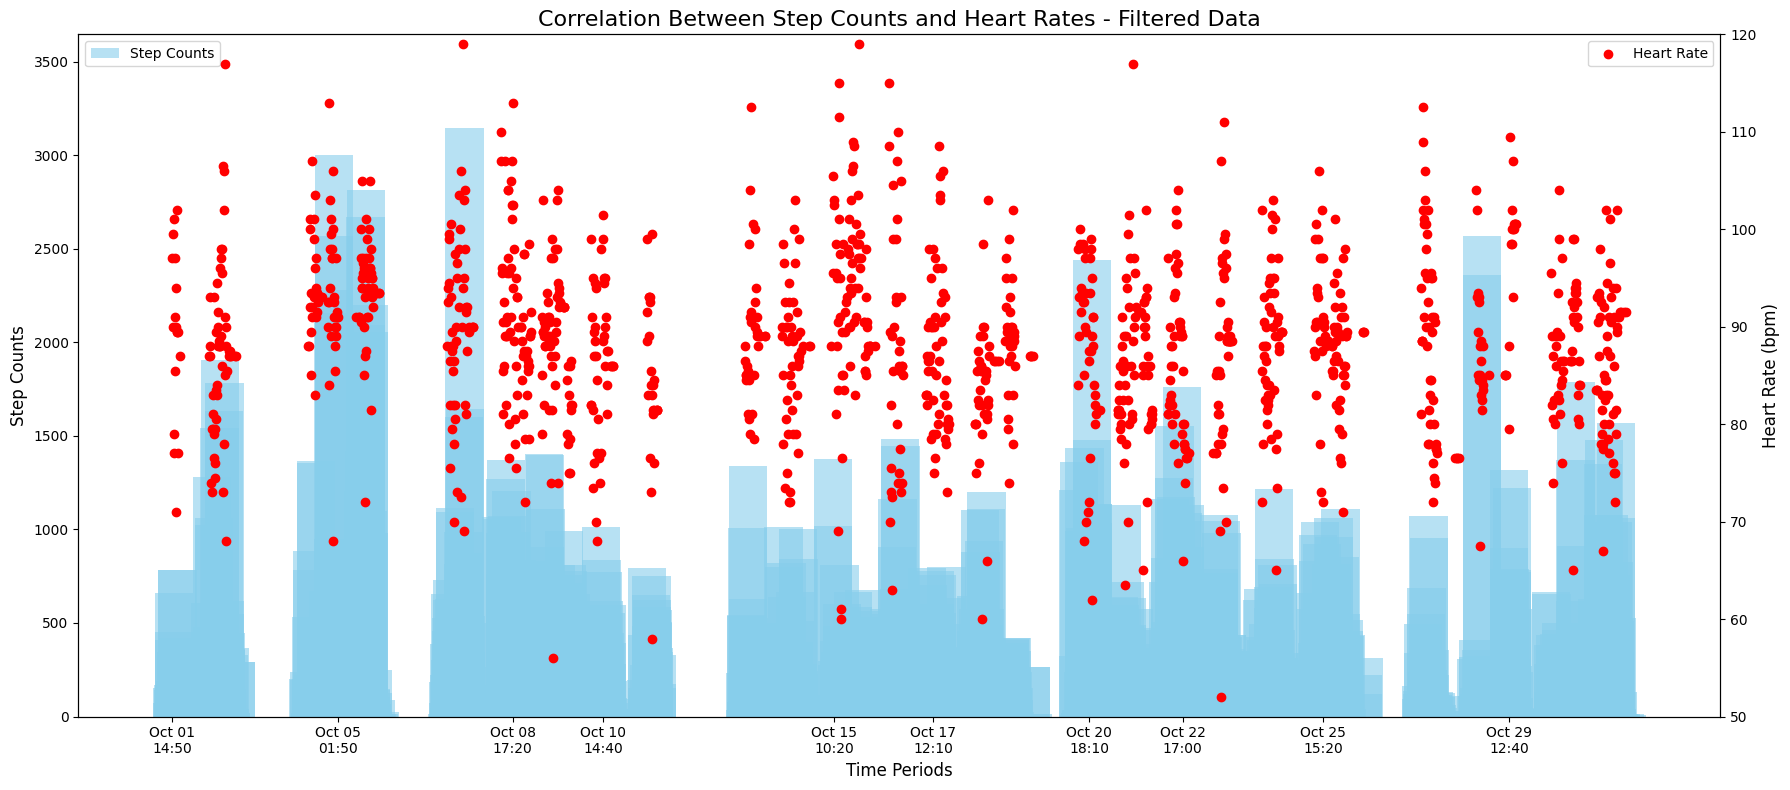

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the heart rate and step count data
heart_rate_file = 'heart_rate_extracted_filled.csv'
step_count_file = 'step_count_extracted_no_fill.csv'

heart_rate_df = pd.read_csv(heart_rate_file)
step_count_df = pd.read_csv(step_count_file)

# Convert 'period' to datetime format
heart_rate_df['period'] = pd.to_datetime(heart_rate_df['period'])
step_count_df['period'] = pd.to_datetime(step_count_df['period'])

# Merge heart rate and step count data on the time period
merged_data = pd.merge(heart_rate_df, step_count_df, on='period', how='inner')

# Filter for nonzero step counts
nonzero_data = merged_data[merged_data['total_steps'] > 0].copy()

# Identify periods with 5 consecutive identical heart rates
nonzero_data['same_heart_rate'] = (
    nonzero_data['mean_heart_rate']
    .rolling(5, min_periods=5)  # Require exactly 5 periods
    .apply(lambda x: len(set(x)) == 1, raw=True)
    .astype(bool)
)

# Exclude periods with 5 consecutive identical heart rates
valid_data = nonzero_data[~nonzero_data['same_heart_rate']]

# Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Bar chart for step counts
ax1.bar(
    valid_data['period'],
    valid_data['total_steps'],
    color='skyblue',
    alpha=0.6,
    label='Step Counts'
)
ax1.set_ylabel('Step Counts', fontsize=12)
ax1.set_ylim(0, valid_data['total_steps'].max() + 500)

# Second axis for heart rate
ax2 = ax1.twinx()
ax2.scatter(
    valid_data['period'],
    valid_data['mean_heart_rate'],
    color='red',
    marker='o',
    label='Heart Rate'
)
ax2.set_ylabel('Heart Rate (bpm)', fontsize=12)
ax2.set_ylim(50, 120)

# Title and legends
ax1.set_title('Correlation Between Step Counts and Heart Rates - Filtered Data', fontsize=16)
ax1.set_xlabel('Time Periods', fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust x-axis for readability
plt.xticks(
    valid_data['period'][::int(len(valid_data) / 10) + 1],  # Reduce x-axis tick density
    labels=[p.strftime('%b %d\n%H:%M') for p in valid_data['period'][::int(len(valid_data) / 10) + 1]],
    rotation=45
)

plt.tight_layout()
plt.show()

The goal of this code is to analyze the correlation between physical activity (step counts) and cardiovascular response (heart rates) by filtering and visualizing periods with meaningful data. It also maintains meaningful data integrity by imputing missing heart rate values using a calculated average of recent data, ensuring continuity in the analysis.
Below is the detailed explanation:

Purpose:
1. Data Filtering:
	-	Merge heart rate and step count data to identify periods where step counts are nonzero.
	-	Exclude periods where the heart rate remains constant for 5 consecutive intervals, as this indicates potential inaccuracies or static readings.
2. Data Imputation for Missing Heart Rates:
	-	For periods with missing heart rate data, calculate the average of the most recent 5, 4, 3, or 2 heart rate values to impute the missing data while preserving meaningful trends.
3. Visualization:
	-	Plot step counts as a bar chart and heart rates as a scatter plot on the same graph to observe correlations between activity levels and cardiovascular responses.
4. Data Integrity:
	-	Focus only on meaningful data by imputing missing values where possible and removing noise and redundant information.

Detailed Functionality:
1.	Merging Data:
  -	Merge heart rate and step count data on the period column to align the two datasets.
  	Use an inner join to retain only matching periods.
2.	Filtering for Nonzero Step Counts:
  -	Extract records where step counts are greater than zero, focusing only on active periods.
3.	Identifying Consecutive Identical Heart Rates:
	-	Use a rolling window of 5 periods to check if all heart rate values in the window are identical.
	-	Mark these periods as static using the same_heart_rate column.
4.	Excluding Static Periods:
	-	Filter out periods marked as same_heart_rate to ensure dynamic and relevant data.
5.	Imputing Missing Heart Rates:
	-	For periods where heart rate data is missing:
	-	Attempt to calculate the average of the last 5 valid heart rate values.
	-	If fewer than 5 valid values are available, reduce the window size to 4, then 3, and finally 2.
	-	Impute the missing value using the calculated average, rounded to the nearest .0 or .5 for consistency.

# Comparison between Active and Resting Periods

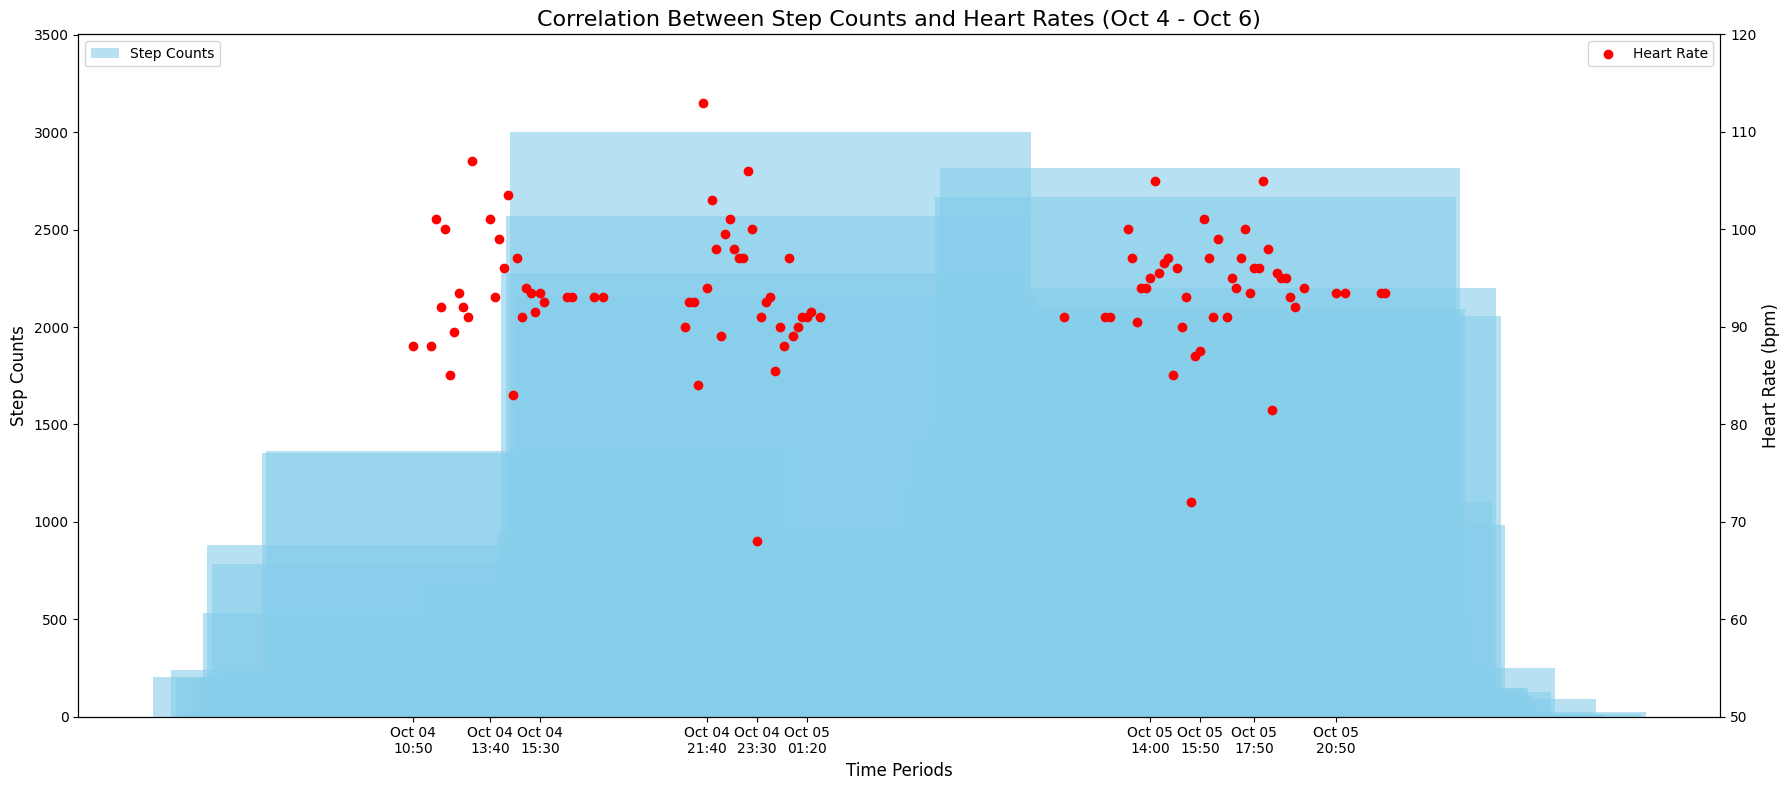

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the heart rate and step count data
heart_rate_file = 'heart_rate_extracted_filled.csv'
step_count_file = 'step_count_extracted_no_fill.csv'

heart_rate_df = pd.read_csv(heart_rate_file)
step_count_df = pd.read_csv(step_count_file)

# Convert 'period' to datetime format
heart_rate_df['period'] = pd.to_datetime(heart_rate_df['period'])
step_count_df['period'] = pd.to_datetime(step_count_df['period'])

# Merge heart rate and step count data on the time period
merged_data = pd.merge(heart_rate_df, step_count_df, on='period', how='inner')

# Filter for nonzero step counts
nonzero_data = merged_data[merged_data['total_steps'] > 0].copy()

# Identify periods with 5 consecutive identical heart rates
nonzero_data['same_heart_rate'] = (
    nonzero_data['mean_heart_rate']
    .rolling(5, min_periods=5)  # Require exactly 5 periods
    .apply(lambda x: len(set(x)) == 1, raw=True)
    .astype(bool)
)

# Exclude periods with 5 consecutive identical heart rates
valid_data = nonzero_data[~nonzero_data['same_heart_rate']]

# Filter for October 4 to October 6
filtered_data = valid_data[
    (valid_data['period'] >= '2024-10-04') & (valid_data['period'] < '2024-10-07')
]

# Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Bar chart for step counts
ax1.bar(
    filtered_data['period'],
    filtered_data['total_steps'],
    color='skyblue',
    alpha=0.6,
    label='Step Counts'
)
ax1.set_ylabel('Step Counts', fontsize=12)
ax1.set_ylim(0, filtered_data['total_steps'].max() + 500)

# Second axis for heart rate
ax2 = ax1.twinx()
ax2.scatter(
    filtered_data['period'],
    filtered_data['mean_heart_rate'],
    color='red',
    marker='o',
    label='Heart Rate'
)
ax2.set_ylabel('Heart Rate (bpm)', fontsize=12)
ax2.set_ylim(50, 120)

# Title and legends
ax1.set_title('Correlation Between Step Counts and Heart Rates (Oct 4 - Oct 6)', fontsize=16)
ax1.set_xlabel('Time Periods', fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust x-axis for readability
plt.xticks(
    filtered_data['period'][::int(len(filtered_data) / 10) + 1],  # Reduce x-axis tick density
    labels=[p.strftime('%b %d\n%H:%M') for p in filtered_data['period'][::int(len(filtered_data) / 10) + 1]],
    rotation=45
)

plt.tight_layout()
plt.show()

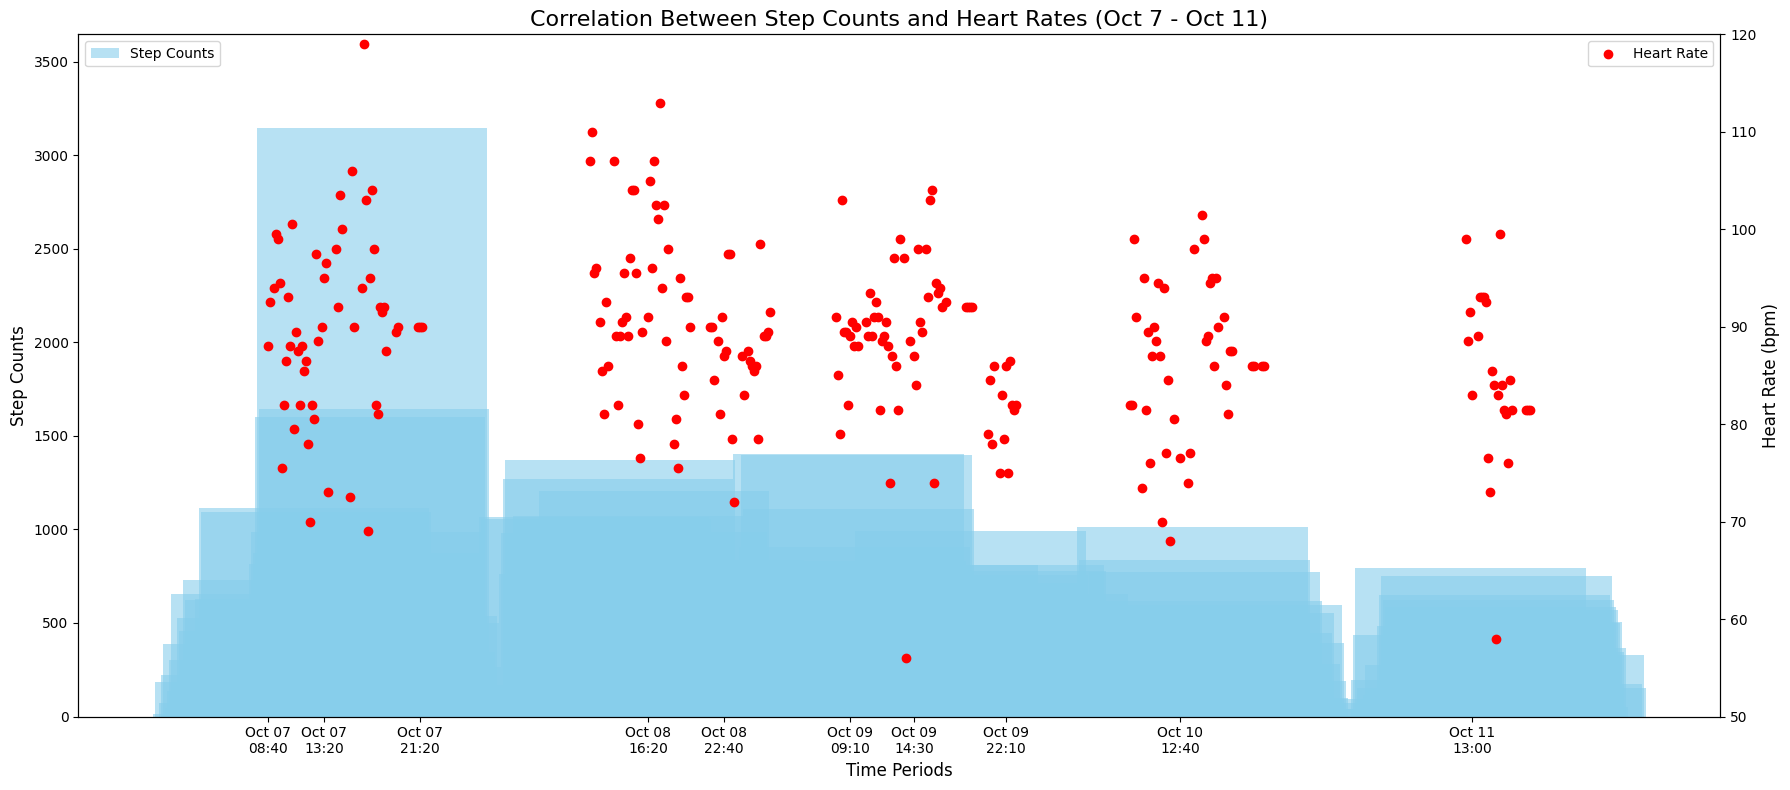

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the heart rate and step count data
heart_rate_file = 'heart_rate_extracted_filled.csv'
step_count_file = 'step_count_extracted_no_fill.csv'

heart_rate_df = pd.read_csv(heart_rate_file)
step_count_df = pd.read_csv(step_count_file)

# Convert 'period' to datetime format
heart_rate_df['period'] = pd.to_datetime(heart_rate_df['period'])
step_count_df['period'] = pd.to_datetime(step_count_df['period'])

# Merge heart rate and step count data on the time period
merged_data = pd.merge(heart_rate_df, step_count_df, on='period', how='inner')

# Filter for nonzero step counts
nonzero_data = merged_data[merged_data['total_steps'] > 0].copy()

# Identify periods with 5 consecutive identical heart rates
nonzero_data['same_heart_rate'] = (
    nonzero_data['mean_heart_rate']
    .rolling(5, min_periods=5)  # Require exactly 5 periods
    .apply(lambda x: len(set(x)) == 1, raw=True)
    .astype(bool)
)

# Exclude periods with 5 consecutive identical heart rates
valid_data = nonzero_data[~nonzero_data['same_heart_rate']]

# Filter for October 7 to October 11
filtered_data = valid_data[
    (valid_data['period'] >= '2024-10-07') & (valid_data['period'] < '2024-10-12')
]

# Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Bar chart for step counts
ax1.bar(
    filtered_data['period'],
    filtered_data['total_steps'],
    color='skyblue',
    alpha=0.6,
    label='Step Counts'
)
ax1.set_ylabel('Step Counts', fontsize=12)
ax1.set_ylim(0, filtered_data['total_steps'].max() + 500)

# Second axis for heart rate
ax2 = ax1.twinx()
ax2.scatter(
    filtered_data['period'],
    filtered_data['mean_heart_rate'],
    color='red',
    marker='o',
    label='Heart Rate'
)
ax2.set_ylabel('Heart Rate (bpm)', fontsize=12)
ax2.set_ylim(50, 120)

# Title and legends
ax1.set_title('Correlation Between Step Counts and Heart Rates (Oct 7 - Oct 11)', fontsize=16)
ax1.set_xlabel('Time Periods', fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust x-axis for readability
plt.xticks(
    filtered_data['period'][::int(len(filtered_data) / 10) + 1],  # Reduce x-axis tick density
    labels=[p.strftime('%b %d\n%H:%M') for p in filtered_data['period'][::int(len(filtered_data) / 10) + 1]],
    rotation=45
)

plt.tight_layout()
plt.show()

Data Granularity:
  
  October 4 to 6 Graph: Focuses on 10-minute intervals, providing detailed insights into active periods.
  
  October 7 to 11 Graph: Also analyzes 10-minute intervals, but highlights stationary periods with lower activity.

Insights:
  
From October 4 to October 6:
  - Step counts are consistently high, indicating active days.
  - Average heart rate is elevated, reflecting increased cardiovascular activity.
  
From October 8 to October 11:
  - Step counts are significantly lower, reflecting more stationary behavior.
  - Heart rate distribution is scattered with occasional fluctuations, but average values are generally lower.

Visualization:
  
October 4 to 6 Graph:

  -	Combines a bar chart (step counts) with a scatter plot (heart rates).

-	Uses color-coded markers to show step intensity.
  October 7 to 11 Graph:

-	Similar combined chart but emphasizes variability in heart rates during low activity.

Focus:
  
October 4 to 6 Graph:

  -	Highlights active days with high step counts and elevated heart rates.

  -	Shows the immediate cardiovascular impact of physical activity.
  
October 7 to 11 Graph:

  -	Focuses on resting periods with lower step counts and scattered heart rates.

  -	Illustrates how reduced activity affects heart rate patterns.

Filters:

  -	Both graphs:

  -	Remove periods with zero step counts.

  -	Exclude static heart rates (consecutive identical values) to focus on meaningful variations.

Annotations:
  
  October 4 to 6 Graph:

  -	Color-coded markers highlight high-intensity activity periods.
  
  October 7 to 11 Graph:

  -	Similar markers but emphasize scattered heart rate patterns in resting periods.

When to Use Each Graph:

October 4 to 6 Graph
  
Use to:

  -	Analyze active periods and their cardiovascular effects.

  -	Explore how high step counts correlate with heart rate spikes.
  
October 7 to 11 Graph

Use to:

  -	Study resting periods and variability in heart rates.

  -	Understand the impact of reduced physical activity on the cardiovascular system.

Conclusion:
  
Active Period Insights (October 4 to 6):

  -	Highlights the relationship between increased activity and elevated heart rates.

  -	Provides insights into the cardiovascular response to physical exertion.
  
Resting Period Insights (October 7 to 11):

  -	Focuses on stationary behavior and scattered heart rates.

  -	Explains how reduced activity reflects on physiological patterns.

By comparing active periods (October 4 to 6) and resting periods (October 7 to 11), these graphs provide a balanced view of physical activity and cardiovascular response, enabling a comprehensive understanding of health dynamics over time.